In [3]:
import ArticleComparator as ac
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup
import random 
import csv 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from Helper import *
from Helper import update_links_df_position
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import ttest_ind 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


pd.options.mode.chained_assignment = None

sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")

from graph import Graph

### **1. Intruduction :**


Todo copy intro from data story 

---
---

### **2. Common Sence Graph Vs Truth Graph**

In [4]:
truth_graph = Graph()
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
truth_graph.update_graph("data/links.tsv", mode='g', verbose=True) # TODO : more appropriate name for mode

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
119769 in the articles graph,
8593 in the categories graph,
210 in the topics graph.


In [5]:
cs_graph = Graph()
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=False) 
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True) 

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
57572 in the articles graph,
6931 in the categories graph,
208 in the topics graph.


As you can see, The players have explored (clicked) on  48% of the total number of present links.
In the following, we will try to analyze and understand the reason binhd it.

---
---

### **3. The semantic's bias on path choice :**


The idea behind this part is to understand how winners navigate through this graph. <br>
More specifically we will try to see how the semantics influnce the choice of the paths by comparing them to the optimal paths. <br><br>
We want to prove that by showing that the semantic similartity between an article in a human's path and the target article is consistently higher than the semantic similarity between an article in an optimal path and the target article. <br>

To do so we will perform two tasks : <br>
1. First we will create two dataframes, `df_paths_finished` and `df_paths_optimal`, which contain resepectively won games and optimal paths found using dijkstra. <br>

2. Then we will compare the semantic similarity over the generated optimal paths and the ones chosen by the players. <br>

3. Finally we will try to visualise this difference in some  examples. <br>

##### **3.1. Creation of df_paths_finished and df_paths_optimal :** <br>

We first start by creating the dataframe `df_paths_finished` that contains all the finished paths.
The data frame will have 4 entries at this stage :
- `path` : which is the list of nodes that the player went through
- `start` : the starting node
- `end` : the ending node
- `length` : the length of the path (number of nodes from start to end, both included)

We read each line of `data/paths_finished.tsv` and fill our dataframe with the consequent data. However we will discard paths where backclicking is done since we want to do a semantic analysis over the path and we want to focus on straightforward paths.

In [6]:
df_paths_finished = create_paths_finished_df(data_path = "data/paths_finished.tsv")
df_paths_finished.sample(5)

Discarded paths due to backclicks:  9052
Number of paths retained:  42266


,path,start,end,length
21051,"[Metamorphic_rock, Mineral, Biology, Plant, Ma...",Metamorphic_rock,Vegetable,6
8420,"[Jesus, Christianity]",Jesus,Christianity,2
13508,"[GNOME, GNU_Project, Richard_Stallman, English...",GNOME,Soil_profile,9
6790,"[United_States, Canada]",United_States,Canada,2
21122,"[Data_Encryption_Standard, Brute_force_attack,...",Data_Encryption_Standard,Maya_mythology,6


For obvious reasons we will also discard trivial paths (length 1), where player won the game just by starting it.

In [7]:
print("Number of trivial paths: ", len(df_paths_finished[df_paths_finished['length'] == 1]))

Number of trivial paths:  11


Similarly we create a dataframe `df_paths_optimal` that contains all the optimal paths, by matching `start` and `end` nodes of `start_end`. <br>

First we retreive the couples `start` and `end` and store them in the `start_end` variable.

In [8]:
#Count number of unique pair of path start and end
start_end = df_paths_finished.groupby(['start','end']).size().reset_index(name='count').sort_values(by='count', ascending=False) 
# store the start and end of the paths in a list
start_end = start_end[['start','end']].values.tolist()
# print the number of unique pair of path start and end
print("Number of unique pair of path start and end: ", len(start_end))

Number of unique pair of path start and end:  25501


We then run `Dijksra` algorithm on the graph to find the shortest path between each pair of `start_end`. We store the result in the  `df_paths_optimal` dataframe.

In [9]:
# Defin the ajecency list of the truth graph
truth_adj = truth_graph.matrix_articles

# Create a dataframe to store the optimal paths
column = ['path' ,'start', 'end', 'length']
df_paths_optimal = pd.DataFrame(columns = column)

# Compute the optimal path for each pair of start and end
#for i in range(len(start_end)):
#    path = dijkstra(truth_adj, start_end[i][0], start_end[i][1])
#    start = start_end[i][0]
#    end = start_end[i][1]
#   length = len(path)
    # Store the optimal path in the dataframe
#    df_paths_optimal.loc[i] = [path, start, end, length]

In [10]:
# read csv df_paths_optimal 
df_paths_optimal = pd.read_csv('data/paths_optimal.csv')

In [11]:
#create a function that converts a string ['Soup', 'Chicken', 'Great_Britain']	to a list [Soup, Chicken, Great Britain]
def convert_string_to_list(string):
    string = string.replace('[','')
    string = string.replace(']','')
    string = string.replace("'",'')
    string = string.replace(" ",'')
    string = string.split(',')
    return string


In [12]:
df_paths_optimal['path']= df_paths_optimal['path'].apply(lambda x: convert_string_to_list(x))

In [13]:
df_paths_optimal.sample(5)

,path,start,end,length
16317,"[Das_Kapital, Capitalism, 16th_century, Vasco_...",Das_Kapital,Vasco_da_Gama,4
12715,"[Tsar_Bomba, Finland, Time_zone, Cape_Town]",Tsar_Bomba,Cape_Town,4
16961,"[Coal, Germany, Austria]",Coal,Austria,3
25414,"[Gold_standard, British_Empire, Great_Britain]",Gold_standard,Great_Britain,3
4063,"[Garage_%28dance_music%29, New_York_City, Alex...",Garage_%28dance_music%29,Theodore_Roosevelt,4


Finally we filter the paths that are too short (length < 3) where it is not possible to analyse the semantic similarity.

In [14]:
# filter df_paths_optimal with length < 3
df_paths_finished_filter = df_paths_finished[df_paths_finished['length'] > 2]
df_paths_optimal = df_paths_optimal[df_paths_optimal['length'] > 2]

print("Number of retained paths from df_paths_finished_filter : ", len(df_paths_finished_filter))
print("Number of retained paths from df_paths_optimal : ", len(df_paths_optimal))

Number of retained paths from df_paths_finished_filter :  41457
Number of retained paths from df_paths_optimal :  24701


##### **3.2 Compare semantic similarity over the optimal path and the one chosen by a player:**

Next, we want to quantify the semantic similarity in the paths. More specifically we want to evaluate the evolution of the semantic closeness to the target at each step of the path by computing: 
- `article_similarity` which is the semantic similarity between the **content** of the target article and the **content** of an article that appears in the path <br>
- `title_similarity` which is the semantic similarity between the **title** of the target article and the **title** of an article that appears in the path. 

In order to compute these metrics we use the pretrianed **BERT** model to compute the embeddings of the articles.
Then we compute the cosine similarity between the embeddings.

We create an object of type `ArticleComparator` that stores the embeddings of the articles and titles, we then use the methods that we implemented to compute the similarity metrics.

In [15]:
article_comparator = ac.ArticleComparator("data/plaintext_articles/", truth_graph.articles)

In [16]:
# For each path, compute the similarity between the articles in the path and the target article
df_paths_finished_filter['article_similarity'] = df_paths_finished_filter.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
df_paths_optimal['article_similarity'] = df_paths_optimal.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
# For each path, compute the similarity between the title articles in the path and the target article title
df_paths_finished_filter['title_similarity'] = df_paths_finished_filter.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)
df_paths_optimal['title_similarity'] = df_paths_optimal.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

In [17]:
df_paths_finished_filter.sample(5)

,path,start,end,length,article_similarity,title_similarity
1106,"[Barbados, United_States, Agriculture, Milk, B...",Barbados,Butter,5,"[0.44, 0.36, 0.57, 0.64, 1.0]","[0.41, 0.48, 0.5, 0.76, 1.0]"
25385,"[Rugby_football, 20th_century, Electronics, Se...",Rugby_football,Semiconductor,4,"[0.4, 0.44, 0.81, 1.0]","[0.24, 0.4, 0.84, 1.0]"
26102,"[Creation-evolution_controversy, Japan, Korea]",Creation-evolution_controversy,Korea,3,"[0.57, 0.73, 1.0]","[0.37, 0.68, 1.0]"
13707,"[Virgil, Homer, Odyssey, Zeus, Greek_mythology...",Virgil,J._R._R._Tolkien,7,"[0.71, 0.7, 0.63, 0.55, 0.67, 0.67, 1.0]","[0.44, 0.49, 0.57, 0.47, 0.39, 0.57, 1.0]"
27414,"[Weasel, Mammal, North_America, United_States,...",Weasel,California,5,"[0.57, 0.57, 0.7, 0.73, 1.0]","[0.3, 0.4, 0.49, 0.63, 1.0]"


In [18]:
df_paths_optimal.sample(5)

,path,start,end,length,article_similarity,title_similarity
21546,"[Lutetium, Hafnium, Boron]",Lutetium,Boron,3,"[0.95, 0.97, 1.0]","[0.68, 0.68, 1.0]"
5579,"[Tropics, Argentina, English_language, HTTP_co...",Tropics,Mozilla_Firefox,5,"[0.52, 0.6, 0.7, 0.72, 1.0]","[0.26, 0.32, 0.23, 0.43, 1.0]"
24255,"[Hatshepsut, Mummy, Eva_Per%C3%B3n, Ronald_Rea...",Hatshepsut,Ronald_Reagan,4,"[0.59, 0.4, 0.61, 1.0]","[0.39, 0.32, 0.43, 1.0]"
15438,"[Boundary_Waters_Canoe_Area_Wilderness, 19th_c...",Boundary_Waters_Canoe_Area_Wilderness,Iranian_peoples,4,"[0.52, 0.62, 0.6, 1.0]","[0.19, 0.4, 0.51, 1.0]"
14710,"[Celtic_Park, Glasgow, List_of_sovereign_state...",Celtic_Park,United_Arab_Emirates,4,"[0.49, 0.68, 0.67, 1.0]","[0.45, 0.47, 0.66, 1.0]"


One problem we faced was that paths found by players are much longer in the `df_paths_finished` dataframe than in the `df_paths_optimal` dataframe, which made it complicated to compare them, and more specifically the evolution of semantic similarity between them. <br>
It is even harder to plot the evolution of semantic similarity over paths of different lengths (which is the core objective of part 3.3). <br>

Thus we decided to **intrapolate** the semantic similarity in the paths. Baisically we link each point to the following one making a linear interpolation.<br> Consequently we have functions describing the evolution of similarity instead of points. Then we sample these functions at a constant rate to get the same number of points regardless of the original length of the path. This task is performed by `get_intrapolation` function implemented in the `Helper` file<br>

For now we only need the `mean_article_similarity` and `mean_title_similarity` of each path. Of course we do not consider the `target` node when computing these metrics. <br>

We find the `mean_article_similarity` and `mean_title_similarity` (in %) of each path by averaging the interpolation points we get from `article_similarity` and `title_similarity`   . <br>

In [19]:
# For each path, compute the similarity between the articles in the path and the end article
df_paths_finished_filter['mean_article_similarity'] = df_paths_finished_filter['article_similarity'].apply(lambda x: get_intrapolation_mean(100, x[:-1] ))
df_paths_optimal['mean_article_similarity'] = df_paths_optimal['article_similarity'].apply(lambda x: get_intrapolation_mean(100, x[:-1] ))
# For each path, compute the similarity between the title articles in the path and the end article title
df_paths_finished_filter['mean_title_similarity'] = df_paths_finished_filter['title_similarity'].apply(lambda x: get_intrapolation_mean(100, x[:-1] ))
df_paths_optimal['mean_title_similarity'] = df_paths_optimal['title_similarity'].apply(lambda x: get_intrapolation_mean(100, x[:-1] ))

We can now combine the two dataframes into one `df_paths` and make sure that each `start` and `end` node appears once for each `tag` (human and optimal). <br>
Otherwise we average the similarity metrics over the different paths so that we can associate a single similarity metric to each `start` and `end` node for each `tag` . <br>

In [20]:
# Add tag to differentiate the two dataframes
df_paths_optimal['tag']= 'optimal'
df_paths_finished_filter['tag']= 'human'
df_paths = pd.concat([df_paths_optimal, df_paths_finished_filter])
# Drop the article_similarity and title_similarity columns since we don't need them anymore
df_paths = df_paths.drop(columns=['article_similarity', 'title_similarity'])
# Grouop by tag, start and end and compute the mean of the similarity
df_paths = df_paths.groupby(['start', 'end', 'tag']).mean().reset_index()
# Group by start and end and keep only when count of tag = 2
df_paths = df_paths.groupby(['start', 'end']).filter(lambda x: len(x) == 2)

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_1362/3323064724.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_paths = df_paths.groupby(['start', 'end', 'tag']).mean().reset_index()


In [21]:
# print number of rows with tag human and number of roxs with tag optimal
print("Number of rows with tag human : ", len(df_paths[df_paths['tag'] == 'human']))
print("Number of rows with tag optimal : ", len(df_paths[df_paths['tag'] == 'optimal']))
df_paths.sample(5)

Number of rows with tag human :  24701
Number of rows with tag optimal :  24701


,start,end,tag,length,mean_article_similarity,mean_title_similarity
21899,Hopman_Cup,Holy_Roman_Empire,human,3.0,61.0,53.0
29753,Milan,African_Great_Lakes,human,5.0,67.0,43.0
2666,Anarcho-capitalism,Petroleum,optimal,4.0,62.0,51.0
24440,Jean-Jacques_Rousseau,Cod,optimal,4.0,53.0,55.0
30944,Music,Vitamin_D,optimal,4.0,50.0,37.0


We can now plot the mean similarity between the articles in the path and the target article for both the human paths and the optimal paths.

Mean similarity between articles content in the path and the content of the target article is 59% for the optimal paths  vs 63 % for human paths. 
Standard deviation of similarity between articles content in the path and the content of the end article is optimal path 9 vs 8 in human paths. 

Mean similarity between articles title in the path and the title of the end article is 46% for the optimal paths  vs 51 % for human paths. 
Standard deviation of similarity between articles title in the path and the title of the target article is 9 for the optimal path  vs 8 in human paths. 


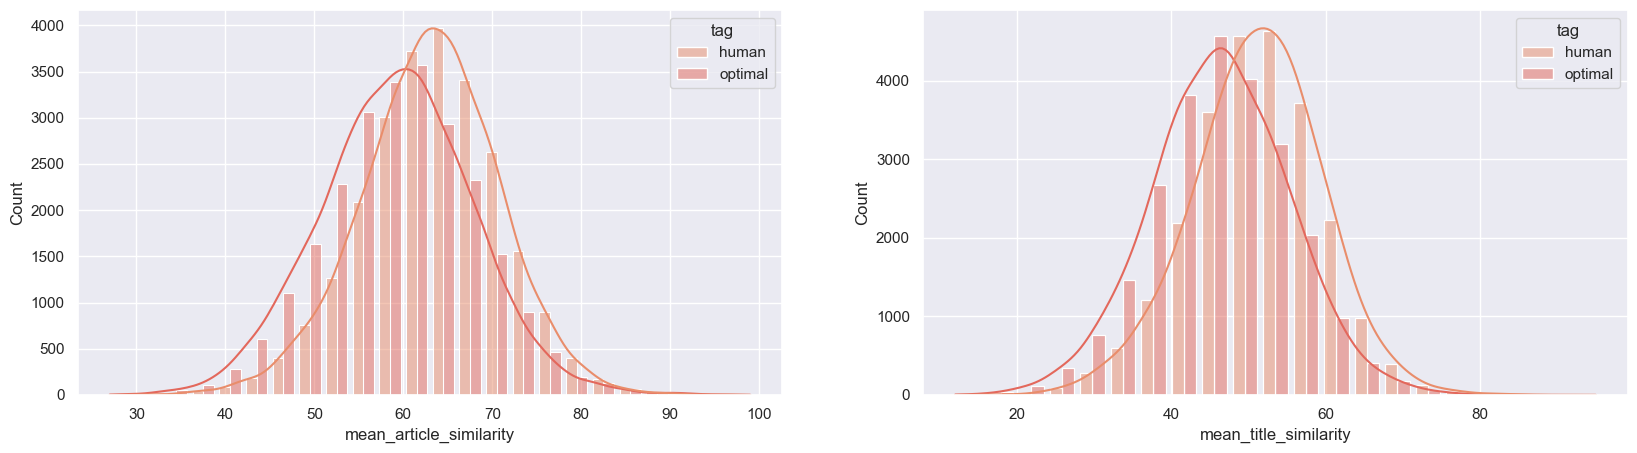

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# Plot the mean similarity with hiplot using the tag as hue
sns.histplot(data=df_paths, x="mean_article_similarity", hue="tag", ax=ax[0], multiple="dodge", shrink=.8, bins= 24, kde=True, kde_kws={"bw_adjust": 1.2})
sns.histplot(data=df_paths, x="mean_title_similarity", hue="tag", ax=ax[1], multiple="dodge", shrink=.8, bins= 21, kde=True,  kde_kws={"bw_adjust": 1.5})
print( "Mean similarity between articles content in the path and the content of the target article is {}% for the optimal paths  vs {} % for human paths. ".format(round(df_paths[df_paths['tag'] == 'optimal']['mean_article_similarity'].mean()), round(df_paths[df_paths['tag'] == 'human']['mean_article_similarity'].mean())))
print( "Standard deviation of similarity between articles content in the path and the content of the end article is optimal path {} vs {} in human paths. ".format(round(df_paths[df_paths['tag'] == 'optimal']['mean_article_similarity'].std()), round(df_paths[df_paths['tag'] == 'human']['mean_article_similarity'].std())))
print()
print( "Mean similarity between articles title in the path and the title of the end article is {}% for the optimal paths  vs {} % for human paths. ".format(round(df_paths[df_paths['tag'] == 'optimal']['mean_title_similarity'].mean()), round(df_paths[df_paths['tag'] == 'human']['mean_title_similarity'].mean())))
print( "Standard deviation of similarity between articles title in the path and the title of the target article is {} for the optimal path  vs {} in human paths. ".format(round(df_paths[df_paths['tag'] == 'optimal']['mean_title_similarity'].std()), round(df_paths[df_paths['tag'] == 'human']['mean_title_similarity'].std())))

In [23]:
# perform a t-test to check if the difference between the two article similarity means is significant
statistic , p_v = ttest_ind(df_paths[df_paths['tag'] == 'optimal']['mean_article_similarity'], df_paths[df_paths['tag'] == 'human']['mean_article_similarity'], equal_var=False)
print('Mean_article_similarity : the t-statistic is %.3f and the p-value is %.3f.' % (statistic, p_v))

# perform a t-test to check if the difference between the two title similarity means is significant
statistic , p_v = ttest_ind(df_paths[df_paths['tag'] == 'optimal']['mean_title_similarity'], df_paths[df_paths['tag'] == 'human']['mean_title_similarity'], equal_var=False)
print('Mean_title_similarity : the t-statistic is %.3f and the p-value is %.3f.' % (statistic, p_v))


Mean_article_similarity : the t-statistic is -50.729 and the p-value is 0.000.
Mean_title_similarity : the t-statistic is -61.110 and the p-value is 0.000.


From the plots and t-test results, We can safely reject the null Hypothesis $H_0$ that the mean similarity is the same for the two metrics between the optimal and human paths as the $p_value=0$. The negative statistics indicate a higher semantic similarity in the human paths compared to the optimal paths.  <br>
 <br>
The average semantic similarity is 5% higher in human paths : A path chosen by a human is 4% closer to the target article content wise than the optimal path and 5% closer title wise.<br>  Besides, the standard deviation is lower in human paths (8 vs 9 in optimal paths), which means that there is less variance in the values.<br>

The semantic similarity is thus higher and denser in human paths than in optimal paths. This means that people have a tendency to click on links that increase the semantic similarity relative to the target<br>

##### **3.1. Visualization of semantic evolution on some paths :** <br>

We now focus on vizualizing the evolution of semantic similarity in the 12 most played games, we start by retreiving them! <br>

In [24]:
# get the 12 most frequent couples of start and end in df_paths_finished_filter
df_paths_finished_filter['start_end'] = df_paths_finished_filter.apply(lambda row: (row['start'],row['end']), axis=1)
popular_games = df_paths_finished_filter['start_end'].value_counts().head(12)
# drop the start_end column
df_paths_finished_filter = df_paths_finished_filter.drop(columns=['start_end'])
popular_games

(Asteroid, Viking)           871
(Brain, Telephone)           843
(Theatre, Zebra)             718
(Pyramid, Bean)              489
(Bird, Great_white_shark)    130
(Batman, Wood)               128
(Batman, The_Holocaust)      106
(Bird, Adolf_Hitler)         100
(Beer, Sun)                   88
(Batman, Banana)              61
(Flower, Adolf_Hitler)        49
(Cat, Computer)               45
Name: start_end, dtype: int64

We only need the `start` and `end` nodes of the most played games that we can retreive from the index

In [25]:
popular_games = popular_games.index.to_list() 

Now we are good to compare the evolution of the semantic similarity with the target in human paths as well as in optimal paths. <br>
We procede as follows : <br>
For each game (couple `start`, `end`): <br>
1. We retreive all the paths corresponding to the game that was played by humans from `df_paths_finished_filter`. <br>
2. We generate random optimal paths (When different ones exist, otherwise we generate only one) that we add to `df_paths_optimal_game`.<br>
3. We intrapolate the semantic similarity in the paths as described before so that paths are comparable. <br>
4. We plot the evolution of semantic similarity in the paths for the human paths and the optimal paths (We take the mean similarity for each step in the path). <br>

In [26]:
def compare_optimal_human_paths (game, ax, similarity="article_similarity" , nb_random_paths = 20):
    """
    Plot the evolution of the evolution of similarity in a path for a given game and a given similarity critertia (article_similarity or title_similarity)

    @param game: tuple of start and end article
    @param ax: matplotlib axis
    @param similarity: similarity criteria to use (article_similarity or title_similarity)
    @param nb_random_paths: number of random paths to generate for the optimal path
    """
    # get all entries where start and end are equal to the test game
    df_paths_finished_filter_game = df_paths_finished_filter[(df_paths_finished_filter['start'] == game[0]) & (df_paths_finished_filter['end'] == game[1])]

    # Generate some random but optimal paths and store them in a dataframe
    column = ['path' ,'start', 'end']
    df_paths_optimal_game = pd.DataFrame(columns = column)
    # Compute nb_random_paths of optimal path for each pair of start and end
    for i in range(nb_random_paths):
        # shuffle the adjacency matrix to get a different path each time
        path= (dijkstra(shufle_dico (truth_adj), game[0] , game[1]))
        df_paths_optimal_game.loc[i] = [path, game[0], game[1]]   
    
    # Compute the similarity between the articles in the path and the end article
    df_paths_optimal_game['article_similarity'] = df_paths_optimal_game.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
    df_paths_optimal_game['title_similarity'] = df_paths_optimal_game.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

    #Interpolate the similarity to have 100 points for each path and make it possible to plot the evolution of the similarity
    df_paths_optimal_game[similarity] = df_paths_optimal_game[similarity].apply(lambda x: get_intrapolation(100, x[:-1]))
    df_paths_finished_filter_game[similarity] = df_paths_finished_filter_game[similarity].apply(lambda x: get_intrapolation(100, x[:-1]))

    # convert the article_similarity to a dataframe that is lineplot friendly
    human_evo = convert_paths_to_df(df_paths_finished_filter_game, similarity)
    optimal_evo = convert_paths_to_df(df_paths_optimal_game, similarity)

    
    # lineplot the article_similarity as a function of the percentage_path
    sns.lineplot(data=human_evo, x="percentage_path", y=similarity, errorbar=('ci', 95), estimator='mean', n_boot=1000, label="Human paths", ax=ax)
    sns.lineplot(data=optimal_evo, x="percentage_path", y=similarity, errorbar=('ci', 95), estimator='mean', n_boot=1000, label="Optimal paths", ax=ax)
    if similarity == "article_similarity":
        ax.set_title("Article similarity evolution, from {} To {} ".format(game[0], game[1]))
    else:
        ax.set_title("Title similarity evolution, from {} To {} ".format(game[0], game[1]))
    ax.set_xlabel("Percentage of path")
    ax.set_ylabel("Similarity")
    ax.legend()


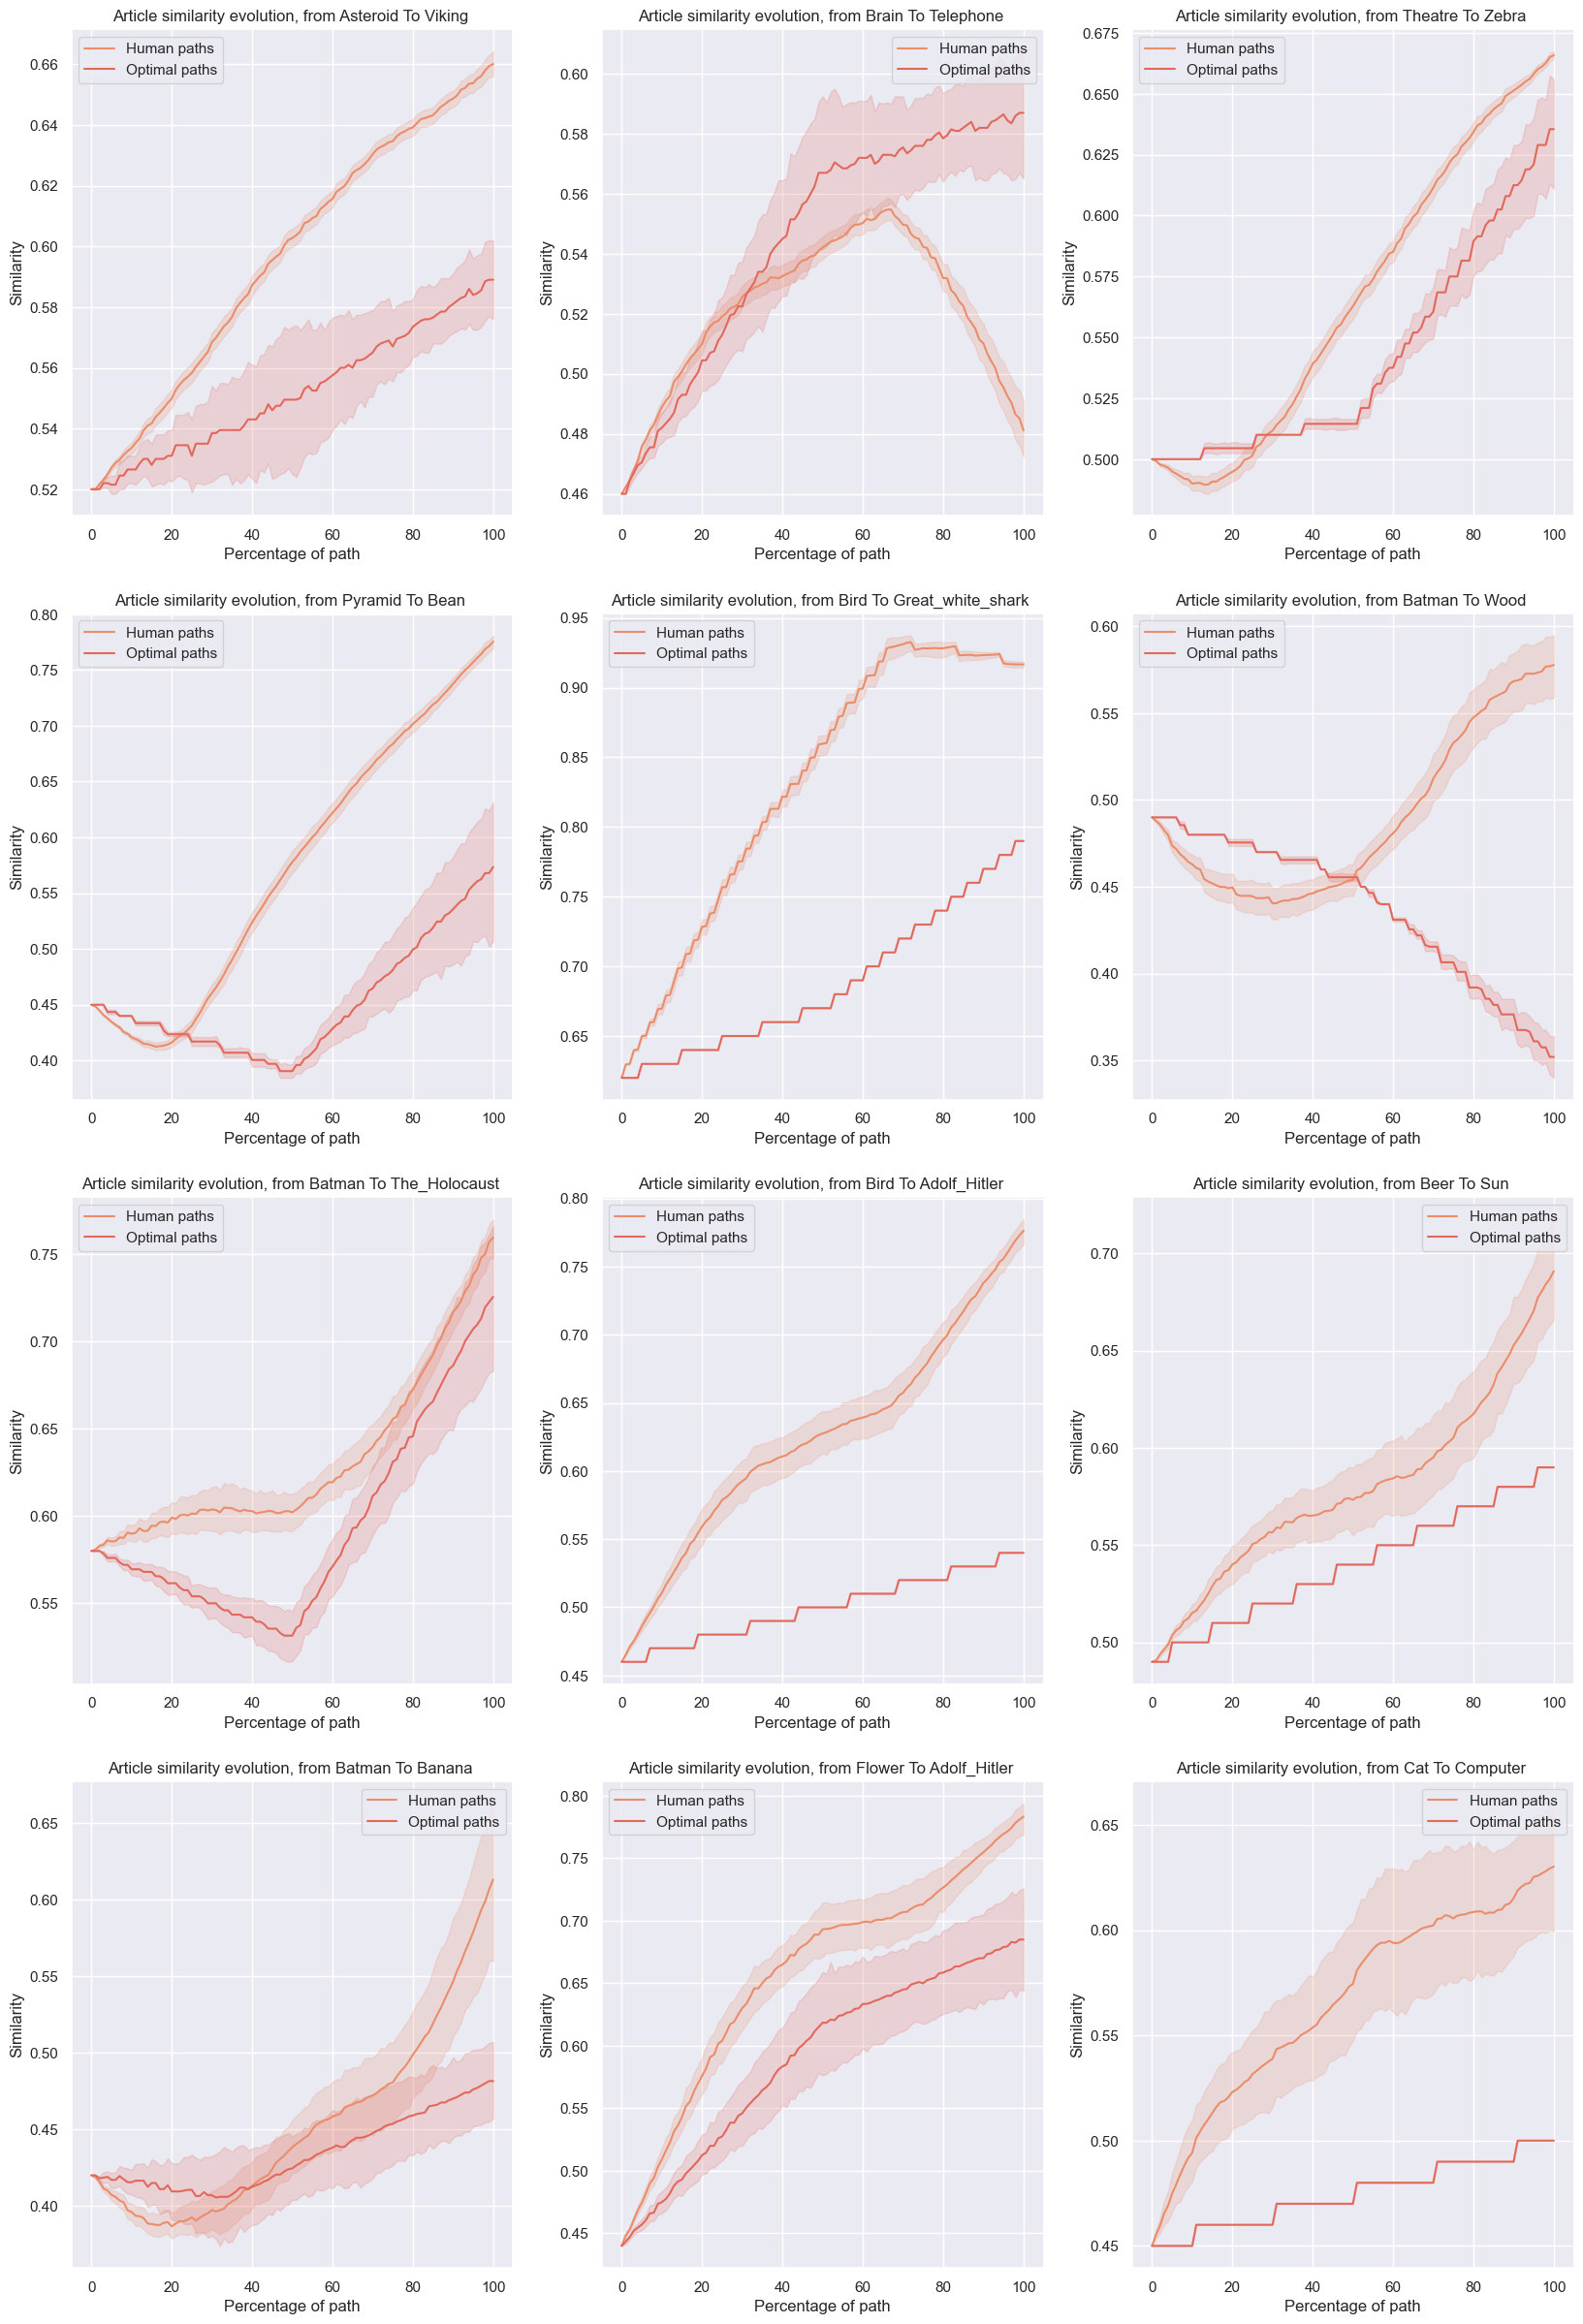

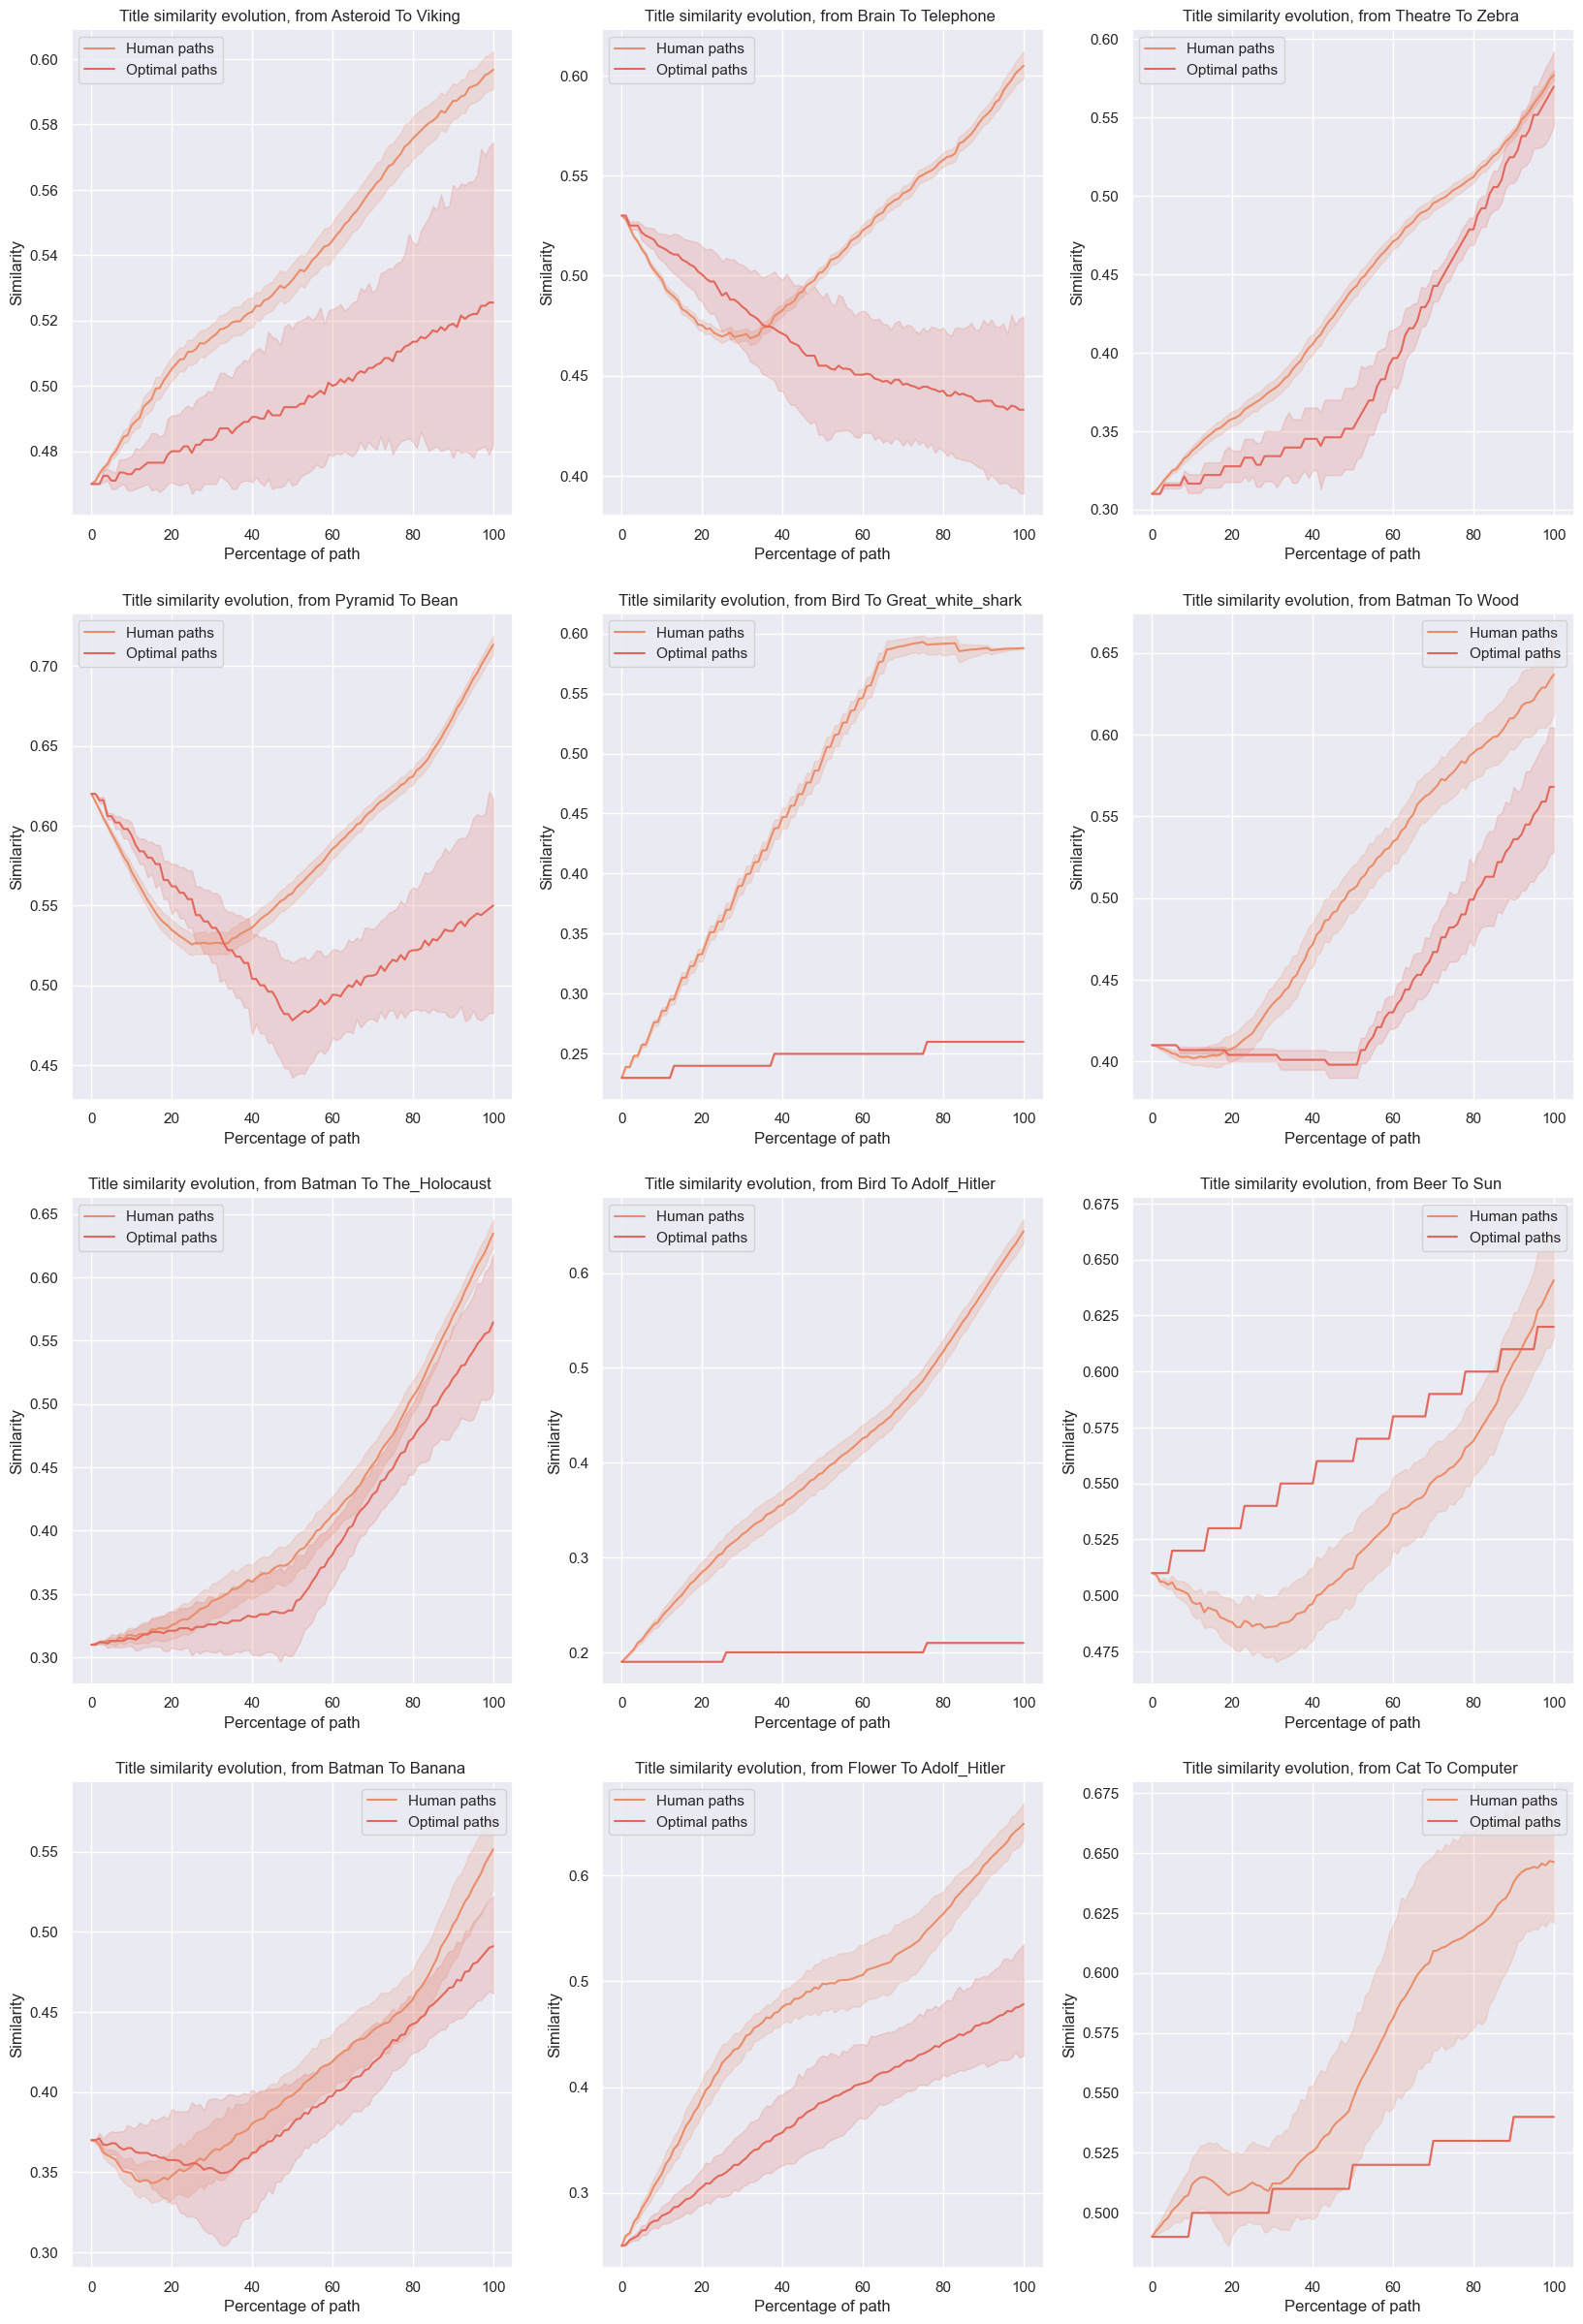

In [27]:
fig , ax = plt.subplots(4,3 ,figsize=(20, 30))
figg , axx = plt.subplots(4,3 ,figsize=(20, 30))
for i,game in enumerate(popular_games):
    compare_optimal_human_paths(game, ax[i//3][i%3], similarity="article_similarity")
    compare_optimal_human_paths(game, axx[i//3][i%3], similarity="title_similarity")
plt.show()

It is obvious that the semantic similarity is higher in human paths than in optimal paths. <br>

The increasing trend of the semantic similarity is clearly visible on 11 of the 12 games of the human paths whereas it is less evident in the generated optimal paths. <br>
In addition, we note a small variance in the semantic meaning of the human paths and a higher variance between the optimal paths for most games.

---
---

### **4. The Influence of the article topology on human behavior:**

In this section, we will try to understand the influence of the article topology (number of links and their relative position) on human behavior. We will try to answer the following questions: <br>

1. How does the click rate on a link change with its position in the article?<br>

2. How does the proportion of clicked links change with the number of existing links in an article? <br>

Both our tasks need information about the position of the links in each article. To do so, let's first create a new data frame, the `links_df` that contains all the existing links in an article and the number of existing links in an article. <br>
This dataframe will contain the following columns: <br>
- `From`: the article containing the link<br>
- `To`: the article that the link leads to <br>
- `positions`: the positions at which the link appears in the `From` article <br>
- `n_links`: The total number of existing links in the `From` article <br>

First we fetch all the links from the `links.tsv` file in order to initialize `From` and `To` entries. <br>

In [28]:
links_df = create_links_df('data/links.tsv')
links_df.sample(5)

,From,To
64721,List_of_European_countries,Bulgaria
83145,Papal_conclave,Monarchy
16229,Blue_Tit,Aphid
59169,John_Calvin,Roman_Empire
41090,Franklin_D._Roosevelt,Battle_of_Midway


Then we retreive the `positions` of each link is each article using the `.html` files. We do so because it is the only way to find them in **the order of appearance in each article**. <br> In this task we use the `BeautifulSoup` library to parse the `.html` files. <br>
Finally we add the `n_links` column to the dataframe. <br>

In [29]:
update_links_df_position(links_df, truth_graph)

In [30]:
# drop nan values
links_df.dropna(inplace=True)
# nb_links column contains only int values
links_df['nb_links'] = links_df['nb_links'].astype(int)
links_df.sample(5)

,From,To,positions,nb_links
34120,Education,Chemistry,[38],43
109010,Tokyo,England,[27],44
94451,S%C3%B8ren_Kierkegaard,Emotion,[19],45
40685,Fr%C3%A9d%C3%A9ric_Chopin,London,[31],46
90060,Rail_transport,Asia,[9],50


Now that our dataframe is ready, we can start answering our questions.

##### **4.1. How does the click rate on a link evolve with its position in the article?**

The weight of a link represents the click rate on the link by the players. It can be retrieved from the common sense graph adjacency matrix <br>
Thus, we add a new column to the links_df dataframe that contains the `weight` of each link. <br>

In [31]:
update_link_df_weights(links_df, cs_graph)
print("Number of links in the dataframe: ", len(links_df))
links_df.sample(5)

Number of links in the dataframe:  119879


,From,To,positions,nb_links,weight
36588,Eritrea,Ethiopia,"[1, 9, 43, 46, 49, 55, 68, 89, 153]",188,1
110928,Turin,Egypt,[23],55,1
22624,Charlie_Chaplin,Silent_film,[5],39,5
52506,Hubble%27s_law,Star,[23],28,0
76255,Music_of_the_Lesser_Antilles,Grenada,"[10, 20]",31,0


Since we want to investigate the effect of the position of the link on the weight, we will keep only the links that have a unique occurence in the article to avoid any bias. <br>

In [32]:
# keep only the positions that are arrays
filtred_links_df = links_df[links_df['positions'].apply(lambda x: isinstance(x, list))]
# keep only the positions that are arrays of length 1
filtred_links_df = filtred_links_df[filtred_links_df['positions'].apply(lambda x: len(x)==1)]
# store positions as int
filtred_links_df['positions'] = filtred_links_df['positions'].apply(lambda x: int(x[0]))
# Add a column with relative position which is position/nb_links
filtred_links_df['relative_position'] = filtred_links_df.apply(lambda row: round(row['positions']/row['nb_links'],2)*100, axis=1)

In [33]:
print("Number of links in the dataframe after filtering non unique links: ", len(filtred_links_df))
filtred_links_df.sample(5)

Number of links in the dataframe after filtering non unique links:  89080


,From,To,positions,nb_links,weight,relative_position
15093,Big_Bang,Hubble_Space_Telescope,22,73,7,30.0
60344,Kangaroo,Rabies,23,24,3,96.0
17355,Brandon_Routh,Music,3,16,0,19.0
46093,Great_Britain,Hebrides,18,55,1,33.0
11270,Autorack,Automobile,0,13,3,0.0


We plot the average weight for each relative position without duplicates in the CS graph.

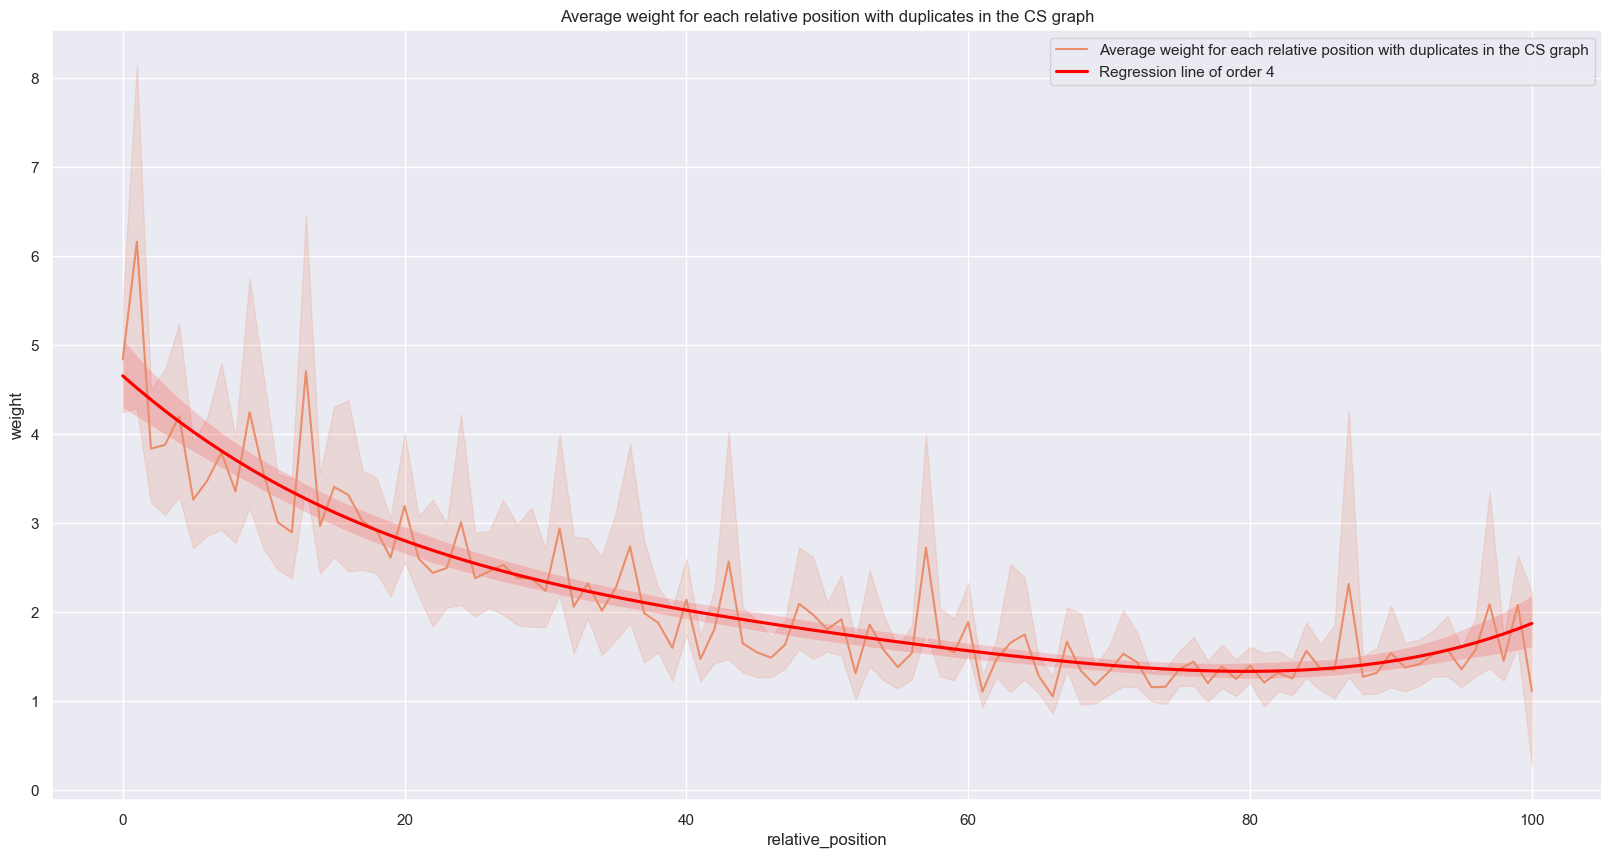

In [34]:
# plot average weight for each relative_position_duplicates
plt.figure(figsize=(20,10))
# Plot the average weight for each relative position without duplicates in the CS graph
sns.lineplot(x=filtred_links_df.relative_position, y=filtred_links_df.weight, data=filtred_links_df, label="Average weight for each relative position with duplicates in the CS graph",legend='full', errorbar=('ci', 95) )
# Add regression line
sns.regplot(x=filtred_links_df.relative_position, y=filtred_links_df.weight, data=filtred_links_df, scatter=False, color="red", label="Regression line of order 4", order= 4)
# legend for ci 
plt.legend(loc='upper right')
plt.title("Average weight for each relative position with duplicates in the CS graph")
plt.show()

We can clearly see a downtrend of the weight as a function of the relative position of the link in the articles.<br>

Links at the beginning of the article are **3 times** more likely to be clicked on than links at a later stage of the article : The average weight of a link at around the 1st percentage of the article $\simeq 4,5$ , while it is $\simeq 1,5$ at 80% of the article. <br>
&rarr; This means that links in the beginning of the article are more likely to be clicked on. <br>

This clearly shows that the relative position of the link in the article is a determinant factor on whether the user will click on it or not.


##### **4.2. How does the proportion of clicked links evolve with the number of existing links in an article?** <br>

Let's go back to our `links_df` dataframe. <br>

In [35]:
links_df.sample(5)

,From,To,positions,nb_links,weight
113915,Venus,Tide,[37],73,0
64825,List_of_North_American_countries,Turks_and_Caicos_Islands,[36],44,0
13251,Battle_of_Britain,Belgium,[43],46,1
42646,Genghis_Khan,Uzbekistan,[16],106,0
69050,Malta,9th_century,[17],50,1


We can also forget about the `positions`  attribute since it is not relevant for our analysis. <br>

Morover we also drop the `nb_links` attribute since we will no longer be interested in the total number of links in the article, but by the number of different links in it. <br>

Thus we define `nb_diff_links` and `nb_explored_links` which will enable us to get the proportion of explored links `prop_explored`  <br>

In [36]:
# define filtred links df as copy of links_df
filtred_links_df = links_df.copy()
# Get rid of the positions column
filtred_links_df.drop(columns=['positions'], inplace=True)
filtred_links_df.drop(columns=['nb_links'], inplace=True)

In [37]:
filtred_links_df.sample(5)

,From,To,weight
26857,Cookiecutter_shark,Whale,1
18136,British_Isles,James_I_of_England,2
10049,Astrophysics_Data_System,English_language,0
25873,Common_Eider,Bird,0
29813,Decade_Volcanoes,Greece,0


In [38]:
# add a column nb_diff_links which count number of unique to for each from
filtred_links_df['nb_diff_links'] = filtred_links_df.groupby('From')['To'].transform('nunique')
filtred_links_df.sample(5)

,From,To,weight,nb_diff_links
50010,History_of_Greece,18th_century,0,78
107438,The_Simpsons,North_America,1,33
75638,Muhammad_ibn_Musa_al-Khwarizmi,Latin,1,23
94704,Saint_Joan_%28play%29,Law,0,5
48794,Henry_Ford,Woodrow_Wilson,4,11


In [39]:
# Drop unexplored links
filtred_links_df = filtred_links_df[filtred_links_df['weight'] != 0]

In [40]:
# group by from and count the number of unique to 
filtred_links_df = filtred_links_df.groupby('From').agg({'To': 'nunique', 'nb_diff_links': 'first'})
# rename the column To to nb_explored_links
filtred_links_df.rename(columns={'To': 'nb_explored_links'}, inplace=True)
# Add a column with the ratio of explored links
filtred_links_df['prop_explored'] = filtred_links_df.apply(lambda row: int(round(row['nb_explored_links']/row['nb_diff_links'],2)*100), axis=1)

In [41]:
#print the number of articles in the dataframe
print("Number of articles in the dataframe with atleast one explored link: ", len(filtred_links_df))
filtred_links_df.sample(5)

Number of articles in the dataframe with atleast one explored link:  4176


,nb_explored_links,nb_diff_links,prop_explored
From,,,
University_of_Texas_at_Austin,5,11,45
Nuclear_power,31,51,61
ZX_Spectrum,6,13,46
Stained_glass,11,14,79
Slovakia,15,34,44


To get a better understanding of the data, we plot the distribution of nb_diff_links in the articles. <br>

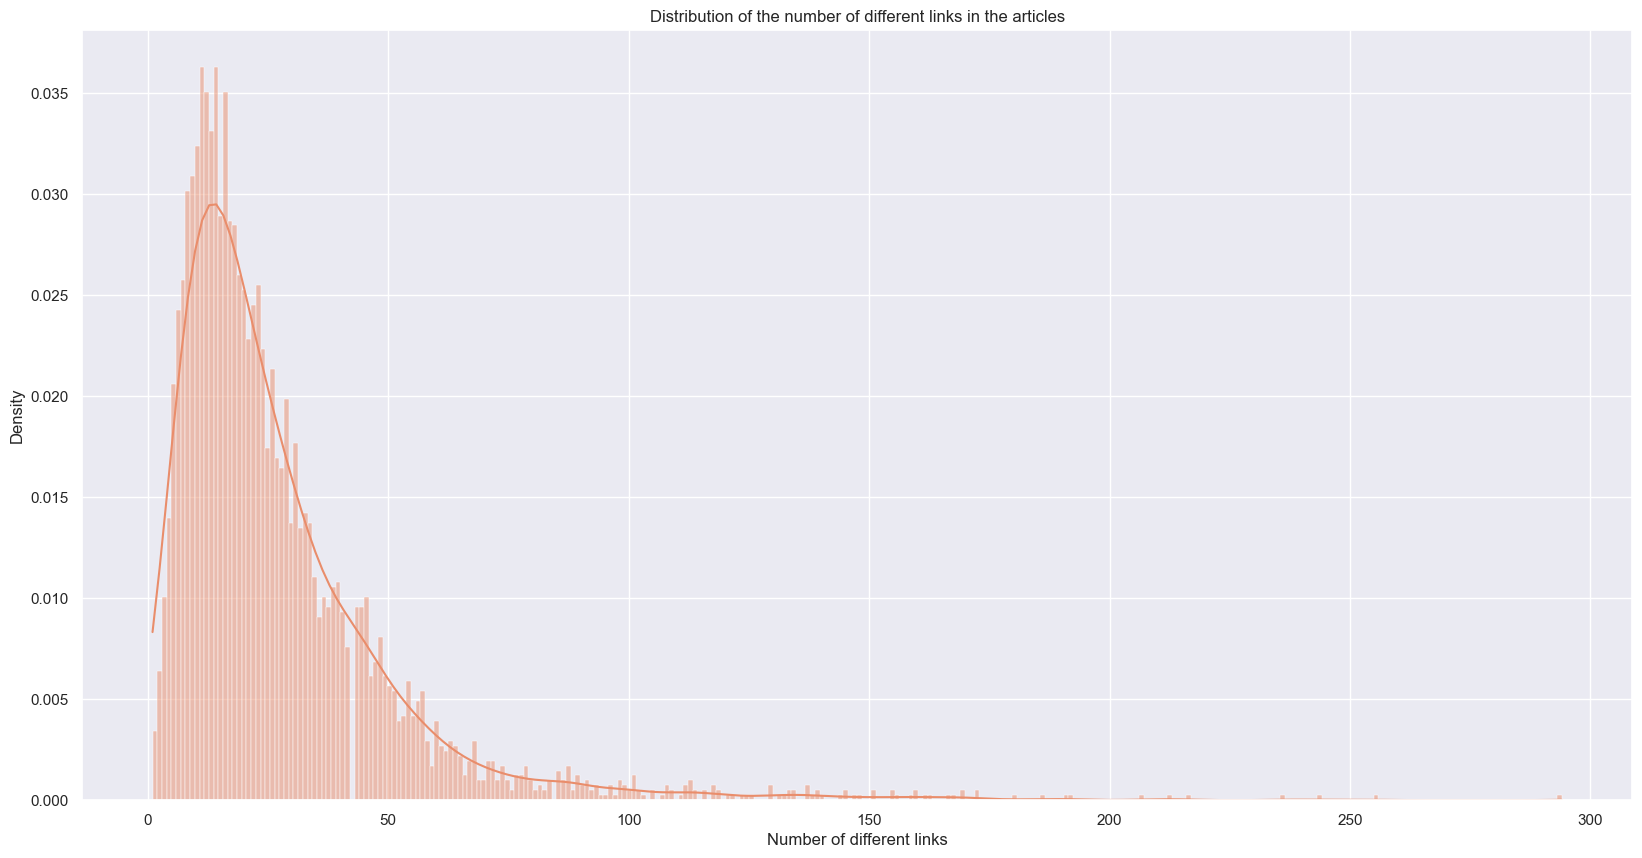

In [42]:
plt.figure(figsize=(20,10))
sns.histplot(filtred_links_df['nb_diff_links'], bins=300 , kde=True, stat='density', label="Distribution of the number of links in articles")
plt.title("Distribution of the number of different links in the articles")
plt.xlabel("Number of different links")
plt.ylabel("Density")
plt.show()

The number of links distribution in articles is skewed to the right. The majority of articles have less than 50 different links. We now have to check if the extreme values are relevant or not. <br>

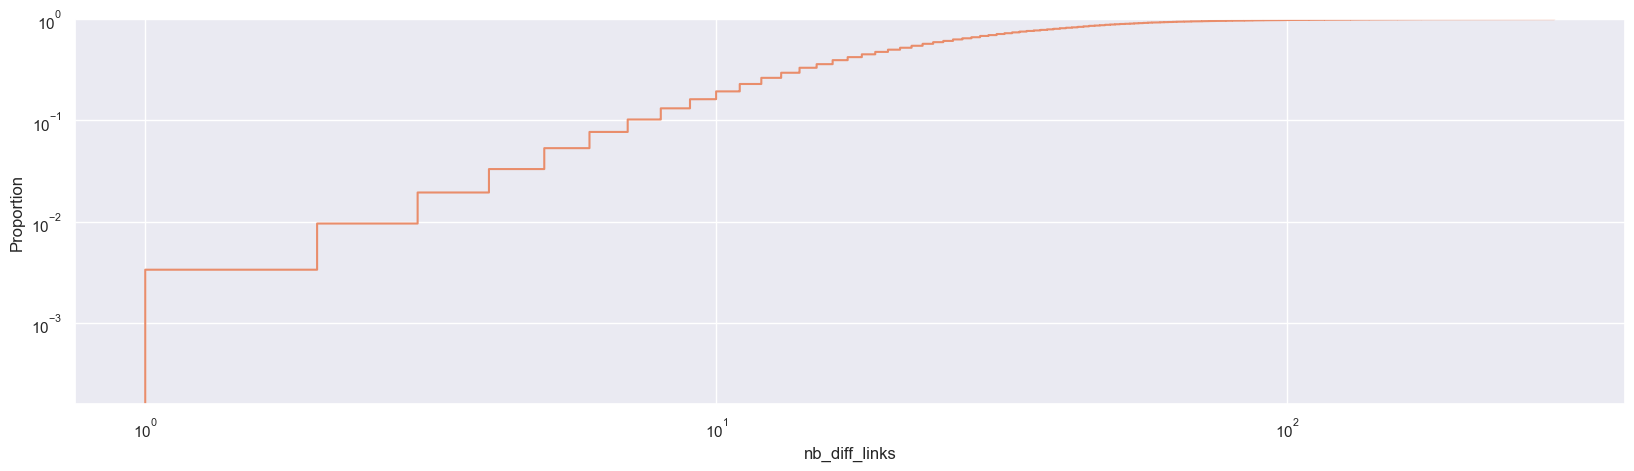

In [43]:
plt.figure(figsize=(20,5))
sns.ecdfplot(data=filtred_links_df, x='nb_diff_links')
plt.xscale('log')
plt.yscale('log')

We can see that the distribution of the number of different links is not heavy tailed, so we can get rid of the outliers. We choose to keep 95% of the data <br>

In [44]:
# keep only 95% of the articles with the less links
filtred_links_df = filtred_links_df[filtred_links_df['nb_diff_links'] < filtred_links_df['nb_diff_links'].quantile(0.95)]

In [45]:
#qort the dataframe by nb_diff_links
filtred_links_df.sort_values(by=['nb_diff_links'], inplace=True, ascending=False)

We plot the same distribution after filtering:

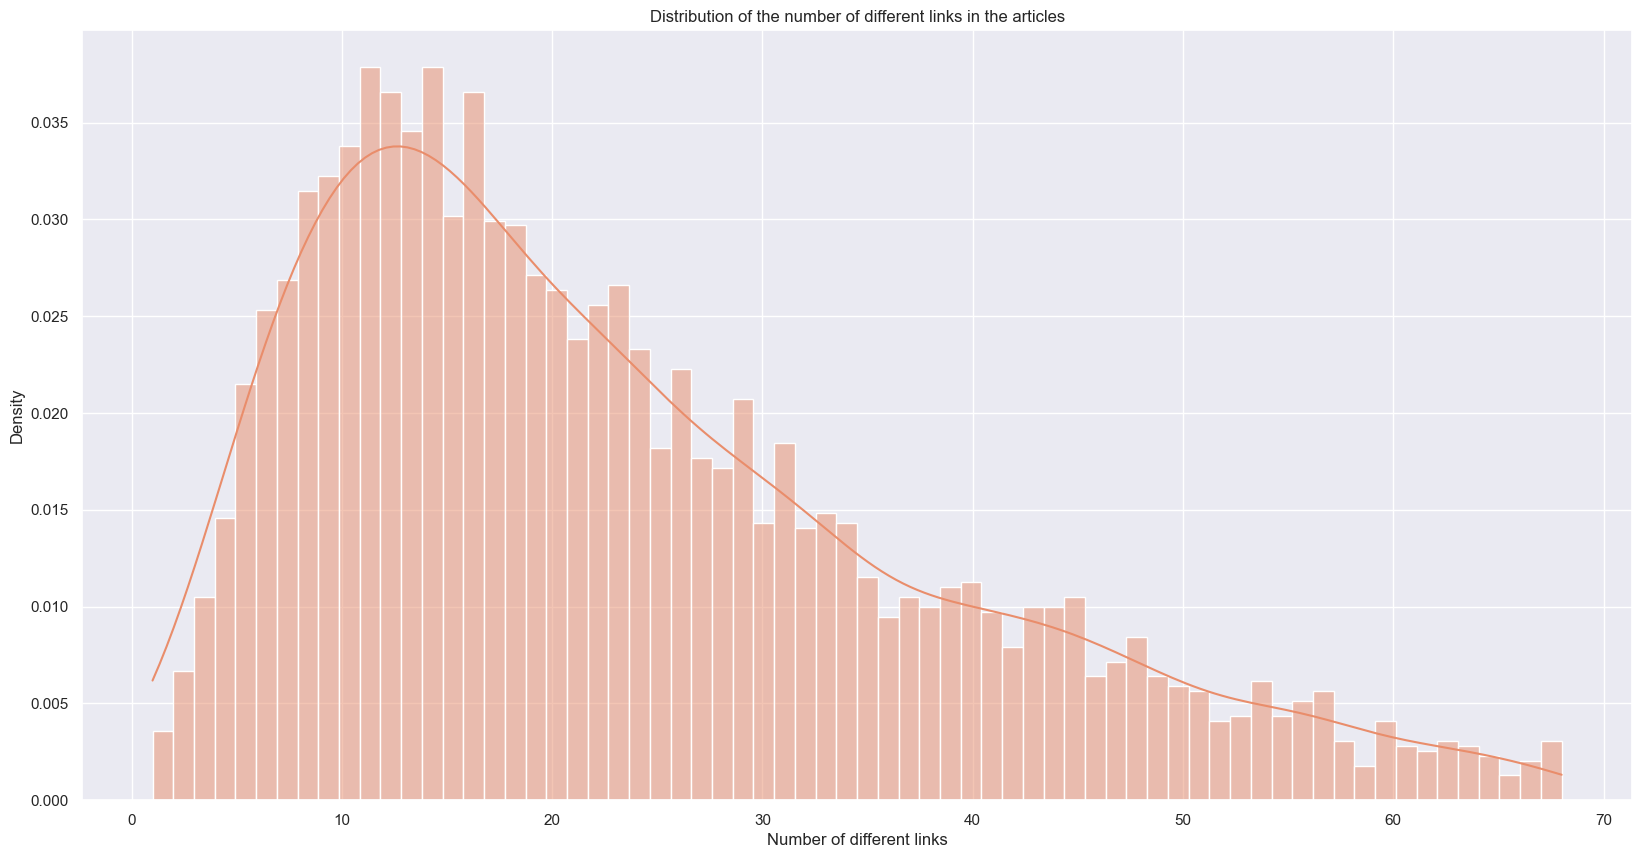

In [46]:
plt.figure(figsize=(20,10))
sns.histplot(filtred_links_df['nb_diff_links'], bins=68 , kde=True, stat='density', label="Distribution of the number of links in articles")
plt.title("Distribution of the number of different links in the articles")
plt.xlabel("Number of different links")
plt.ylabel("Density")
plt.show()

Let's examine the relationship between the number of different links and the proportion of explored links. <br>

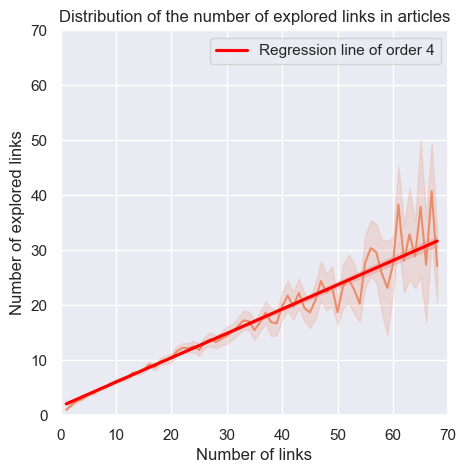

In [47]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(5,5))
sns.lineplot(data=filtred_links_df, x="nb_diff_links", y="nb_explored_links", errorbar=('ci',90))
sns.regplot(data=filtred_links_df, x="nb_diff_links", y="nb_explored_links", scatter=False, color="red", label="Regression line of order 4", order= 1)
plt.title("Distribution of the number of explored links in articles")
# set x in range 0 to 70
plt.xlim(0,70)
plt.ylim(0,70)

plt.legend()
plt.xlabel("Number of links")
plt.ylabel("Number of explored links")
plt.show()

We can clearly distinguish a linear relationship between the number of different links and the proportion of explored links :on avearge, people explore $\simeq 45$% of the links in an article. <br>

Let's see how this proportion evolves with the number of different links in an article. <br>

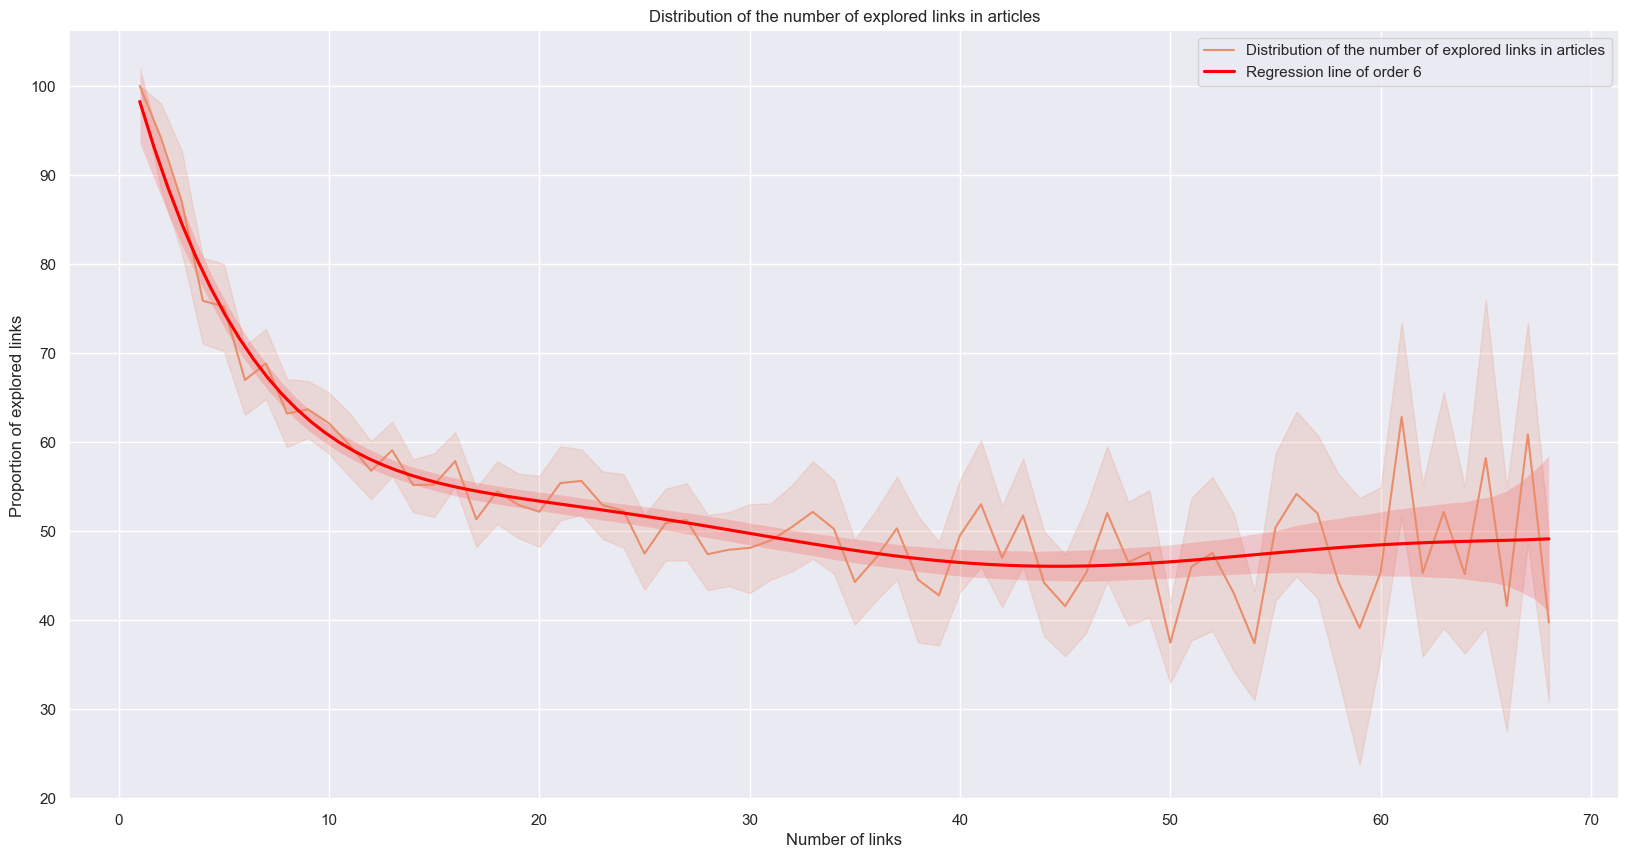

In [48]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=filtred_links_df, x="nb_diff_links", y="prop_explored", label="Distribution of the number of explored links in articles", errorbar=('ci',90))
sns.regplot(data=filtred_links_df, x="nb_diff_links", y="prop_explored", scatter=False, color="red", label="Regression line of order 6", order= 6, ci=90)
plt.title("Distribution of the number of explored links in articles")
plt.legend()
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()

We can clearly see that the proportion of explored links decreases as the number of different links increases. <br>
For articles with less than 10 different links, the proportion of explored links starts high but decreases very fast.<br>
Starting from 10 different links, the proportion of explored links keeps decreasing but at a slower rate.<br>


---
---

### **5. How good are the discussed parameters to predict human behavior?**

Until now we discussed 2 main parameters that can explain why people would click on a link: <br>
- **Semantic similarity** between the link and the target. <br>
- **Topology of the article** with the positionning of the links and their number. <br>


Now, we will try to see how accurate these paramters are in determining whether a link will be clicked on or not. We call it **mate in one** analysis <br>

We will construct a datafame that compiles actual game situations where a user was in an article that had a link to the target article. <br> 
- Success events will be labeled as `1` and will correspond to the last click in all finished paths. <br>
- Failure events will be labeled as `0` and will correspond to the compilation of links in paths that had a link to the target article but were not clicked. <br>

Again, we will need our `links_df` dataframe to get the position of the link in the article as well as the df_paths_finished. <br>

In [49]:
links_df.sample(5)

,From,To,positions,nb_links,weight
113056,University_of_Chicago,Economics,[24],41,2
98880,Sino-Roman_relations,Indian_Ocean,"[31, 36]",43,0
19296,Butter,Mesopotamia,[19],61,1
39696,Flag_of_India,Indian_independence_movement,[5],26,0
25071,Cocoa,Alchemy,[18],37,1


In [50]:
#set From and To as index
links_df.set_index(['From','To'], inplace=True)

In [51]:
with open('data/df_paths_finished.pickle', 'rb') as handle:
    df_paths_finished = pickle.load(handle)
df_paths_finished.sample(5)

,path,start,end,length,article_similarity,title_similarity
12935,"[Fire, Plant, Tree, Seed, Fruit, Apple]",Fire,Apple,6,"[0.31, 0.6, 0.69, 0.73, 0.8, 1.0]","[0.3, 0.58, 0.59, 0.53, 0.73, 1.0]"
22926,"[Synthesizer, Telephone, Great_Britain, United...",Synthesizer,Pound_sterling,5,"[0.37, 0.57, 0.67, 0.72, 1.0]","[0.37, 0.46, 0.65, 0.59, 1.0]"
6846,"[United_States_Declaration_of_Independence, Un...",United_States_Declaration_of_Independence,Erie_Canal,4,"[0.74, 0.65, 0.71, 1.0]","[0.42, 0.46, 0.52, 1.0]"
31390,"[Durian, Insect, Landform, Continent, Africa, ...",Durian,Tutsi,6,"[0.59, 0.56, 0.49, 0.59, 0.68, 1.0]","[0.62, 0.4, 0.46, 0.55, 0.58, 1.0]"
13006,"[Norway, European_Union, France, Monaco, Formu...",Norway,Monaco_Grand_Prix,6,"[0.59, 0.67, 0.61, 0.65, 0.9, 1.0]","[0.29, 0.38, 0.35, 0.77, 0.61, 1.0]"


We will now combine the information for both the l`inks_df` and `df_paths_finished` to get the `missed_winning_link` and `found_winning_link` dataframe.<br>
Each row of the dataframe will contain the following information: <br>
- `article`: the article from which the winning link appears <br>
- `target`: the target article <br>
- `article_similarity`: semantic similarity between the content of the two articles <br>
- `title_similarity`: semantic similarity between the titles of the two articles <br>
- `link_position`: the position of the link in the article <br>
- `nb_links`: the number of links in the article <br> 


In [52]:
# We create a dataframe to store the missed winning occasions
missed_winning_link = pd.DataFrame(columns=['article', 'target', 'article_similarity', 'title_similarity', 'link_position', 'nb_links' ])
counter_not_found = 0
# We create a dataframe to store the found winning occasions
found_winning_link = pd.DataFrame(columns=['article', 'target', 'article_similarity', 'title_similarity', 'link_position', 'nb_links'])
counter_found = 0

# We iterate over the paths
for i in range(len(df_paths_finished)):
    # define the target article
    target_article =  df_paths_finished.iloc[i,2]
    # get the path from the dataframe
    path = df_paths_finished.iloc[i,0]
    # get the similarity of the articles array
    path_sim_article = df_paths_finished.iloc[i,4]
    # get the similarity of the titles array
    path_sim_title = df_paths_finished.iloc[i,5]

    # For each article in the path
    for j in range(len(path)-1): 
        # If there exists a link between the article and the target article
        if target_article in truth_graph.matrix_articles[path[j]].keys():
            
            # get the position of the link
            position = links_df.loc[path[j], target_article]['positions']
            # get the number of links in the article
            nb_links = links_df.loc[path[j], target_article]['nb_links']

            # Tretment for found_winning_link
            if j == len(path)-2 :
                found_winning_link.loc[counter_found] = [path[j], target_article, path_sim_article[j], path_sim_title[j], position, nb_links ]
                counter_found = counter_found +1 
            # Tretment for missed_winning_link
            else :
                # iterate over all positions with index
                for i, index in enumerate(position):
                    missed_winning_link.loc[counter_not_found] = [path[j], target_article, path_sim_article[j], path_sim_title[j], index, nb_links]
                    counter_not_found = counter_not_found+1

In [53]:
print("Number of missed winning links : ", len(missed_winning_link))
missed_winning_link.sample(5)

Number of missed winning links :  10894


,article,target,article_similarity,title_similarity,link_position,nb_links
4848,Periodic_table,Chlorine,0.68,0.64,25,142
215,Solar_System,Moon,0.85,0.63,111,121
9362,United_Kingdom,Cardiff,0.75,0.58,111,249
10035,5th_century,6th_century,0.80,0.79,1,43
2614,Europe,Sweden,0.61,0.59,214,464


In [54]:
print("Number of found winning links : ", len(found_winning_link))
found_winning_link.sample(5)

Number of found winning links :  42254


,article,target,article_similarity,title_similarity,link_position,nb_links
41486,William_II_of_England,England,0.84,0.77,[5],27
24293,Europe,Sweden,0.61,0.59,"[58, 214, 273, 303, 398, 420, 440, 458]",464
39961,Mammal,Zebra,0.65,0.55,[68],70
39960,Lion,Zebra,0.68,0.62,[30],53
17551,DNA,James_D._Watson,0.75,0.60,[],38


When the winning link appears in different positions in the article, since we do not know which of the positions was clicked, we will discard the entire article from our compilation so that we do not have any bias.<br>

In [55]:
#keep only rows where link_position is of length 1
found_winning_link = found_winning_link[found_winning_link['link_position'].apply(lambda x: len(x) == 1)]
# convert link_position to int
found_winning_link['link_position'] = found_winning_link['link_position'].apply(lambda x: x[0]) 


In [56]:
print("Number of found winning links : ", len(found_winning_link))

Number of found winning links :  21620


In [57]:
# comparison of the mean and the median of similarities and positions between found_winning_link and missed_winning_link
for column in ['article_similarity', 'title_similarity', 'link_position', 'nb_links']:
    print("Average ", column , " in found_winning_link vs missed_winning_link: ", round(np.mean(found_winning_link[column]), 2), round(np.mean(missed_winning_link[column]), 2))
    print("Median ", column , " in found_winning_link vs missed_winning_link: ", round(np.median(found_winning_link[column]), 2), round(np.median(missed_winning_link[column]), 2))
    print()

Average  article_similarity  in found_winning_link vs missed_winning_link:  0.69 0.7
Median  article_similarity  in found_winning_link vs missed_winning_link:  0.7 0.7

Average  title_similarity  in found_winning_link vs missed_winning_link:  0.61 0.59
Median  title_similarity  in found_winning_link vs missed_winning_link:  0.61 0.59

Average  link_position  in found_winning_link vs missed_winning_link:  40.18 94.56
Median  link_position  in found_winning_link vs missed_winning_link:  25.0 61.0

Average  nb_links  in found_winning_link vs missed_winning_link:  93.73 175.94
Median  nb_links  in found_winning_link vs missed_winning_link:  66.0 125.0



We can now create a new dataframe `games_df` that combines both `found_winning_link` and `missed_winning_link` dataframes. <br>

In [58]:
# Add label to the dataframes
found_winning_link['label'] = 1
missed_winning_link['label'] = 0

# Concatenate the dataframes
games_df = pd.concat([found_winning_link, missed_winning_link], ignore_index=True)
print("Size of the dataframe: ", len(games_df))
games_df.sample(5)

Size of the dataframe:  32514


,article,target,article_similarity,title_similarity,link_position,nb_links,label
24637,Japan,North_Korea,0.76,0.58,62,141,0
29330,Black_hole,String_theory,0.79,0.35,16,44,0
18341,Greenland,Snow,0.60,0.55,34,46,1
28639,China,Qing_Dynasty,0.75,0.64,65,127,0
24754,The_Holocaust,Greece,0.58,0.41,36,112,0


Finally we can train a `Random Forest Classifier` on the `article_similarity`, `title_similarity`, `link_position` and 	`nb_links` attributes to predict whether the user will click on the link or not. <br>

In [59]:
# create a random forest classifier that uses the article similarity, title similarity, position of article in path and position of link in article to predict label
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=3)
features = ['article_similarity', 'title_similarity', 'link_position', 'nb_links']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(games_df[features], games_df['label'], test_size=0.2, random_state=0)

# train the classifier
clf.fit(X_train, y_train)

# predict the labels of the test set
y_pred = clf.predict(X_test)
# print the accuracy of the classifier
print("Accuracy: ", round(clf.score(X_test, y_test),2)*100, "%")
print('f1 score: ', round(f1_score(y_test, y_pred),2))
print('precision score: ', round(precision_score(y_test, y_pred),2))
print('recall score: ', round(recall_score(y_test, y_pred),2))


importances = clf.feature_importances_
# get indices of the most important features
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(features)):
    print("%d.  %s (%d%%) " %  (f + 1, features[indices[f]], int(round(importances[indices[f]],2)*100)))


Accuracy:  82.0 %
f1 score:  0.87
precision score:  0.83
recall score:  0.92
Feature ranking:
1.  nb_links (32%) 
2.  link_position (28%) 
3.  title_similarity (20%) 
4.  article_similarity (20%) 


The `RandomForestClassifier` gives a good f1, precisiom and recall scores. <br>
We can conclude the chosen metrics are good predictors of human behavior since we correctly guess if the article is found 82% of the times! <br>
<br>
Next, we try to further analyze how the number of links and the position of the target article influence the probability of missing article. <br>
For that, we do a linear regression on the `nb_links` and `link_position` attributes to predict the probability of missing the article `label` (between 0 and 1) <br>


In [60]:
mod = smf.ols(formula='label ~ nb_links + link_position', data=games_df)
# Fit the model
res = mod.fit()
# Print the summary of the model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2514.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:20:58   Log-Likelihood:                -19387.
No. Observations:               32514   AIC:                         3.878e+04
Df Residuals:                   32511   BIC:                         3.881e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8294      0.004    236.456

From the above, we can see that the probability of missing the article decreases as the number of links increases, as well as, its position in the article.<br>
Both features, have negative  coefficients (-0.0015, -0.006) with a p-value of 0.0, which means that they are statistically significant. <br>
<br>
We conclude that the position of a link is important in determining whether a user will click on it or not. <br>
The decrease in the probability of missing the article as the number of links increases can be explained by an increasing number of choices overwhelms the player, which pushes him to make a wrong move. <br>

---
---

In [61]:
def vertices_to_df(graph, level):
    assert level in graph.authorized_levels
    _, verteces = graph.levels_map[level]
    header =["Topic", "Category", "degree", "out_degree", "in_degree", "total_weight" ,"total_weight_out", "total_weight_in","average_weight_per_edge", "average_weight_out", "average_weight_in"]  
    if level == "categories":
        header.remove("Category")
        header.append("nb_articles")
        header.append("nb_seen_articles")
    if level == "topics":
        header.remove("Topic")
        header.remove("Category")
        header.append("nb_categories")
        header.append("nb_articles")
        header.append("nb_seen_articles")
    
    df = pd.DataFrame(columns=header)
    for vertex in verteces.values():
        nb_unique_outgoing_edges = vertex.get_nb_different_out_neighbours()
        nb_unique_incoming_edges = vertex.get_nb_different_in_neighbours()
        nb_unique_edges = nb_unique_outgoing_edges + nb_unique_incoming_edges
        
        if (nb_unique_edges != 0) :
            total_weight_out = vertex.get_total_out_weight()
            total_weight_in = vertex.get_total_in_weight()
            total_weight = total_weight_out + total_weight_in
            average_weight_out = round(total_weight_out/nb_unique_outgoing_edges, 2) if nb_unique_outgoing_edges != 0 else 0
            average_weight_in = round(total_weight_in/nb_unique_incoming_edges,2) if nb_unique_incoming_edges != 0 else 0
            average_weight_per_edge = round(total_weight/nb_unique_edges, 2)

            if level == "articles":
                df.loc[vertex.title] = [vertex.topic, vertex.category, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in]
                df["Topic"].astype("category")
                df["Category"].astype("category")
            elif level == "categories":
                df.loc[vertex.title]= [vertex.topic, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_articles(),vertex.get_nb_seen_articles()]
                df["Topic"].astype("category")
            else:
                df.loc[vertex.title]= [nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_categories(), vertex.get_nb_different_articles(),vertex.get_nb_seen_articles()]
    return df

In [62]:
df_articles_truth = vertices_to_df(truth_graph, level="articles")

In [63]:
df_paths_finished = create_paths_finished_df(data_path = "data/paths_finished.tsv")

Discarded paths due to backclicks:  9052
Number of paths retained:  42266


In [64]:
df_paths_finished_degree= df_paths_finished.copy()
# keep path	start	end	length from optimal_paths
df_optimal_paths_degree = df_paths_optimal[['path', 'start', 'end', 'length']]
# filter paths with less than 3 articles
df_paths_finished_degree = df_paths_finished_degree[df_paths_finished_degree['length'] > 2]

In [65]:
# for each entry in path in path_finished get out_degree    
df_paths_finished_degree['path_degree_out'] = df_paths_finished_degree['path'].apply(lambda path: [df_articles_truth.loc[article]['out_degree'] for article in path])
df_optimal_paths_degree['path_degree_out'] = df_optimal_paths_degree['path'].apply(lambda path: [df_articles_truth.loc[article]['out_degree'] for article in path])

In [66]:
df_paths_finished_degree.head(5)

,path,start,end,length,path_degree_out
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9,"[31, 57, 91, 87, 125, 13, 212, 58, 24]"
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5,"[31, 159, 212, 58, 24]"
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8,"[31, 44, 67, 129, 102, 212, 58, 24]"
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4,"[31, 63, 65, 114]"
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7,"[31, 85, 55, 16, 89, 56, 68]"


In [67]:
df_paths_finished_degree['path_degree_out'] = df_paths_finished_degree['path_degree_out'].apply(lambda x: get_intrapolation_mean(100, x[:-1]))
df_optimal_paths_degree['path_degree_out'] = df_optimal_paths_degree['path_degree_out'].apply(lambda x: get_intrapolation_mean(100, x[:-1]))

In [68]:
df_paths_finished_degree.head(5)

,path,start,end,length,path_degree_out
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9,8947
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5,13756
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8,9920
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4,5543
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7,5756


In [69]:
# Add tag to differentiate the two dataframes
df_optimal_paths_degree['tag']= 'optimal'
df_paths_finished_degree['tag']= 'human'
df_paths = pd.concat([df_optimal_paths_degree, df_paths_finished_degree])
# Grouop by tag, start and end and compute the mean of centrality
df_paths = df_paths.groupby(['start', 'end', 'tag']).mean().reset_index()
# Group by start and end and keep only when count of tag = 2
df_paths = df_paths.groupby(['start', 'end']).filter(lambda x: len(x) == 2)

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_1362/2770141548.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_paths = df_paths.groupby(['start', 'end', 'tag']).mean().reset_index()


In [70]:
df_paths

,start,end,tag,length,path_degree_out
0,%E2%82%AC2_commemorative_coins,Irish_Sea,human,3.0,5900.0
1,%E2%82%AC2_commemorative_coins,Irish_Sea,optimal,3.0,8600.0
2,10th_century,Banknote,human,5.0,3983.0
3,10th_century,Banknote,optimal,3.0,6900.0
4,10th_century,Country,human,3.0,9750.0
...,...,...,...,...,...
49664,Zulu,Jesus,optimal,3.0,3200.0
49665,Zulu,Language,human,3.0,6650.0
49666,Zulu,Language,optimal,3.0,1400.0
49667,Zulu,Slovenia,human,4.5,7529.0


<AxesSubplot: xlabel='path_degree_out', ylabel='Count'>

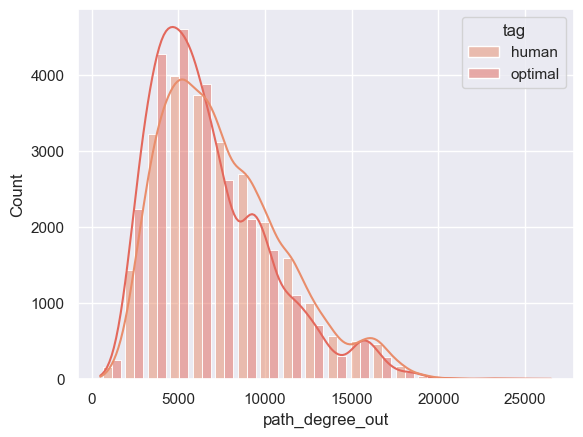

In [71]:
# plot the centrality of the paths
sns.histplot(data=df_paths, x="path_degree_out", hue="tag", multiple="dodge", bins=20, kde=True,  shrink=.8)

In [72]:
def compare_optimal_human_paths (game, ax, similarity="path_degree_out" , nb_random_paths = 20):
    """
    Plot the evolution of the evolution of similarity in a path for a given game and a given similarity critertia (article_similarity or title_similarity)

    @param game: tuple of start and end article
    @param ax: matplotlib axis
    @param similarity: similarity criteria to use (article_similarity or title_similarity)
    @param nb_random_paths: number of random paths to generate for the optimal path
    """
    # get all entries where start and end are equal to the test game
    df_paths_finished_degree_game = df_paths_finished_degree[(df_paths_finished_degree['start'] == game[0]) & (df_paths_finished_degree['end'] == game[1])]

    # Generate some random but optimal paths and store them in a dataframe
    column = ['path' ,'start', 'end']
    df_paths_optimal_game = pd.DataFrame(columns = column)
    # Compute nb_random_paths of optimal path for each pair of start and end
    for i in range(nb_random_paths):
        # shuffle the adjacency matrix to get a different path each time
        path= (dijkstra(shufle_dico (truth_adj), game[0] , game[1]))
        df_paths_optimal_game.loc[i] = [path, game[0], game[1]]   
    
    # Compute the similarity between the articles in the path and the end article
    df_paths_optimal_game['path_degree_out'] = df_paths_optimal_game['path'].apply(lambda path: [df_articles_truth.loc[article]['out_degree'] for article in path])
    df_paths_finished_degree_game ['path_degree_out'] = df_paths_finished_degree_game['path'].apply(lambda path: [df_articles_truth.loc[article]['out_degree'] for article in path])

    #Interpolate the similarity to have 100 points for each path and make it possible to plot the evolution of the similarity
    df_paths_optimal_game[similarity] = df_paths_optimal_game[similarity].apply(lambda x: get_intrapolation(100, x))
    df_paths_finished_degree_game[similarity] = df_paths_finished_degree_game[similarity].apply(lambda x: get_intrapolation(100, x))

    # convert the article_similarity to a dataframe that is lineplot friendly
    human_evo = convert_paths_to_df(df_paths_finished_degree_game, similarity)
    optimal_evo = convert_paths_to_df(df_paths_optimal_game, similarity)

    
    # lineplot the article_similarity as a function of the percentage_path
    sns.lineplot(data=human_evo, x="percentage_path", y=similarity, errorbar=('ci', 95), estimator='mean', n_boot=1000, label="Human paths", ax=ax)
    sns.lineplot(data=optimal_evo, x="percentage_path", y=similarity, errorbar=('ci', 95), estimator='mean', n_boot=1000, label="Optimal paths", ax=ax)
    
    ax.set_xlabel("Percentage of path")
    ax.set_ylabel("Centrality of the node")
    ax.legend()



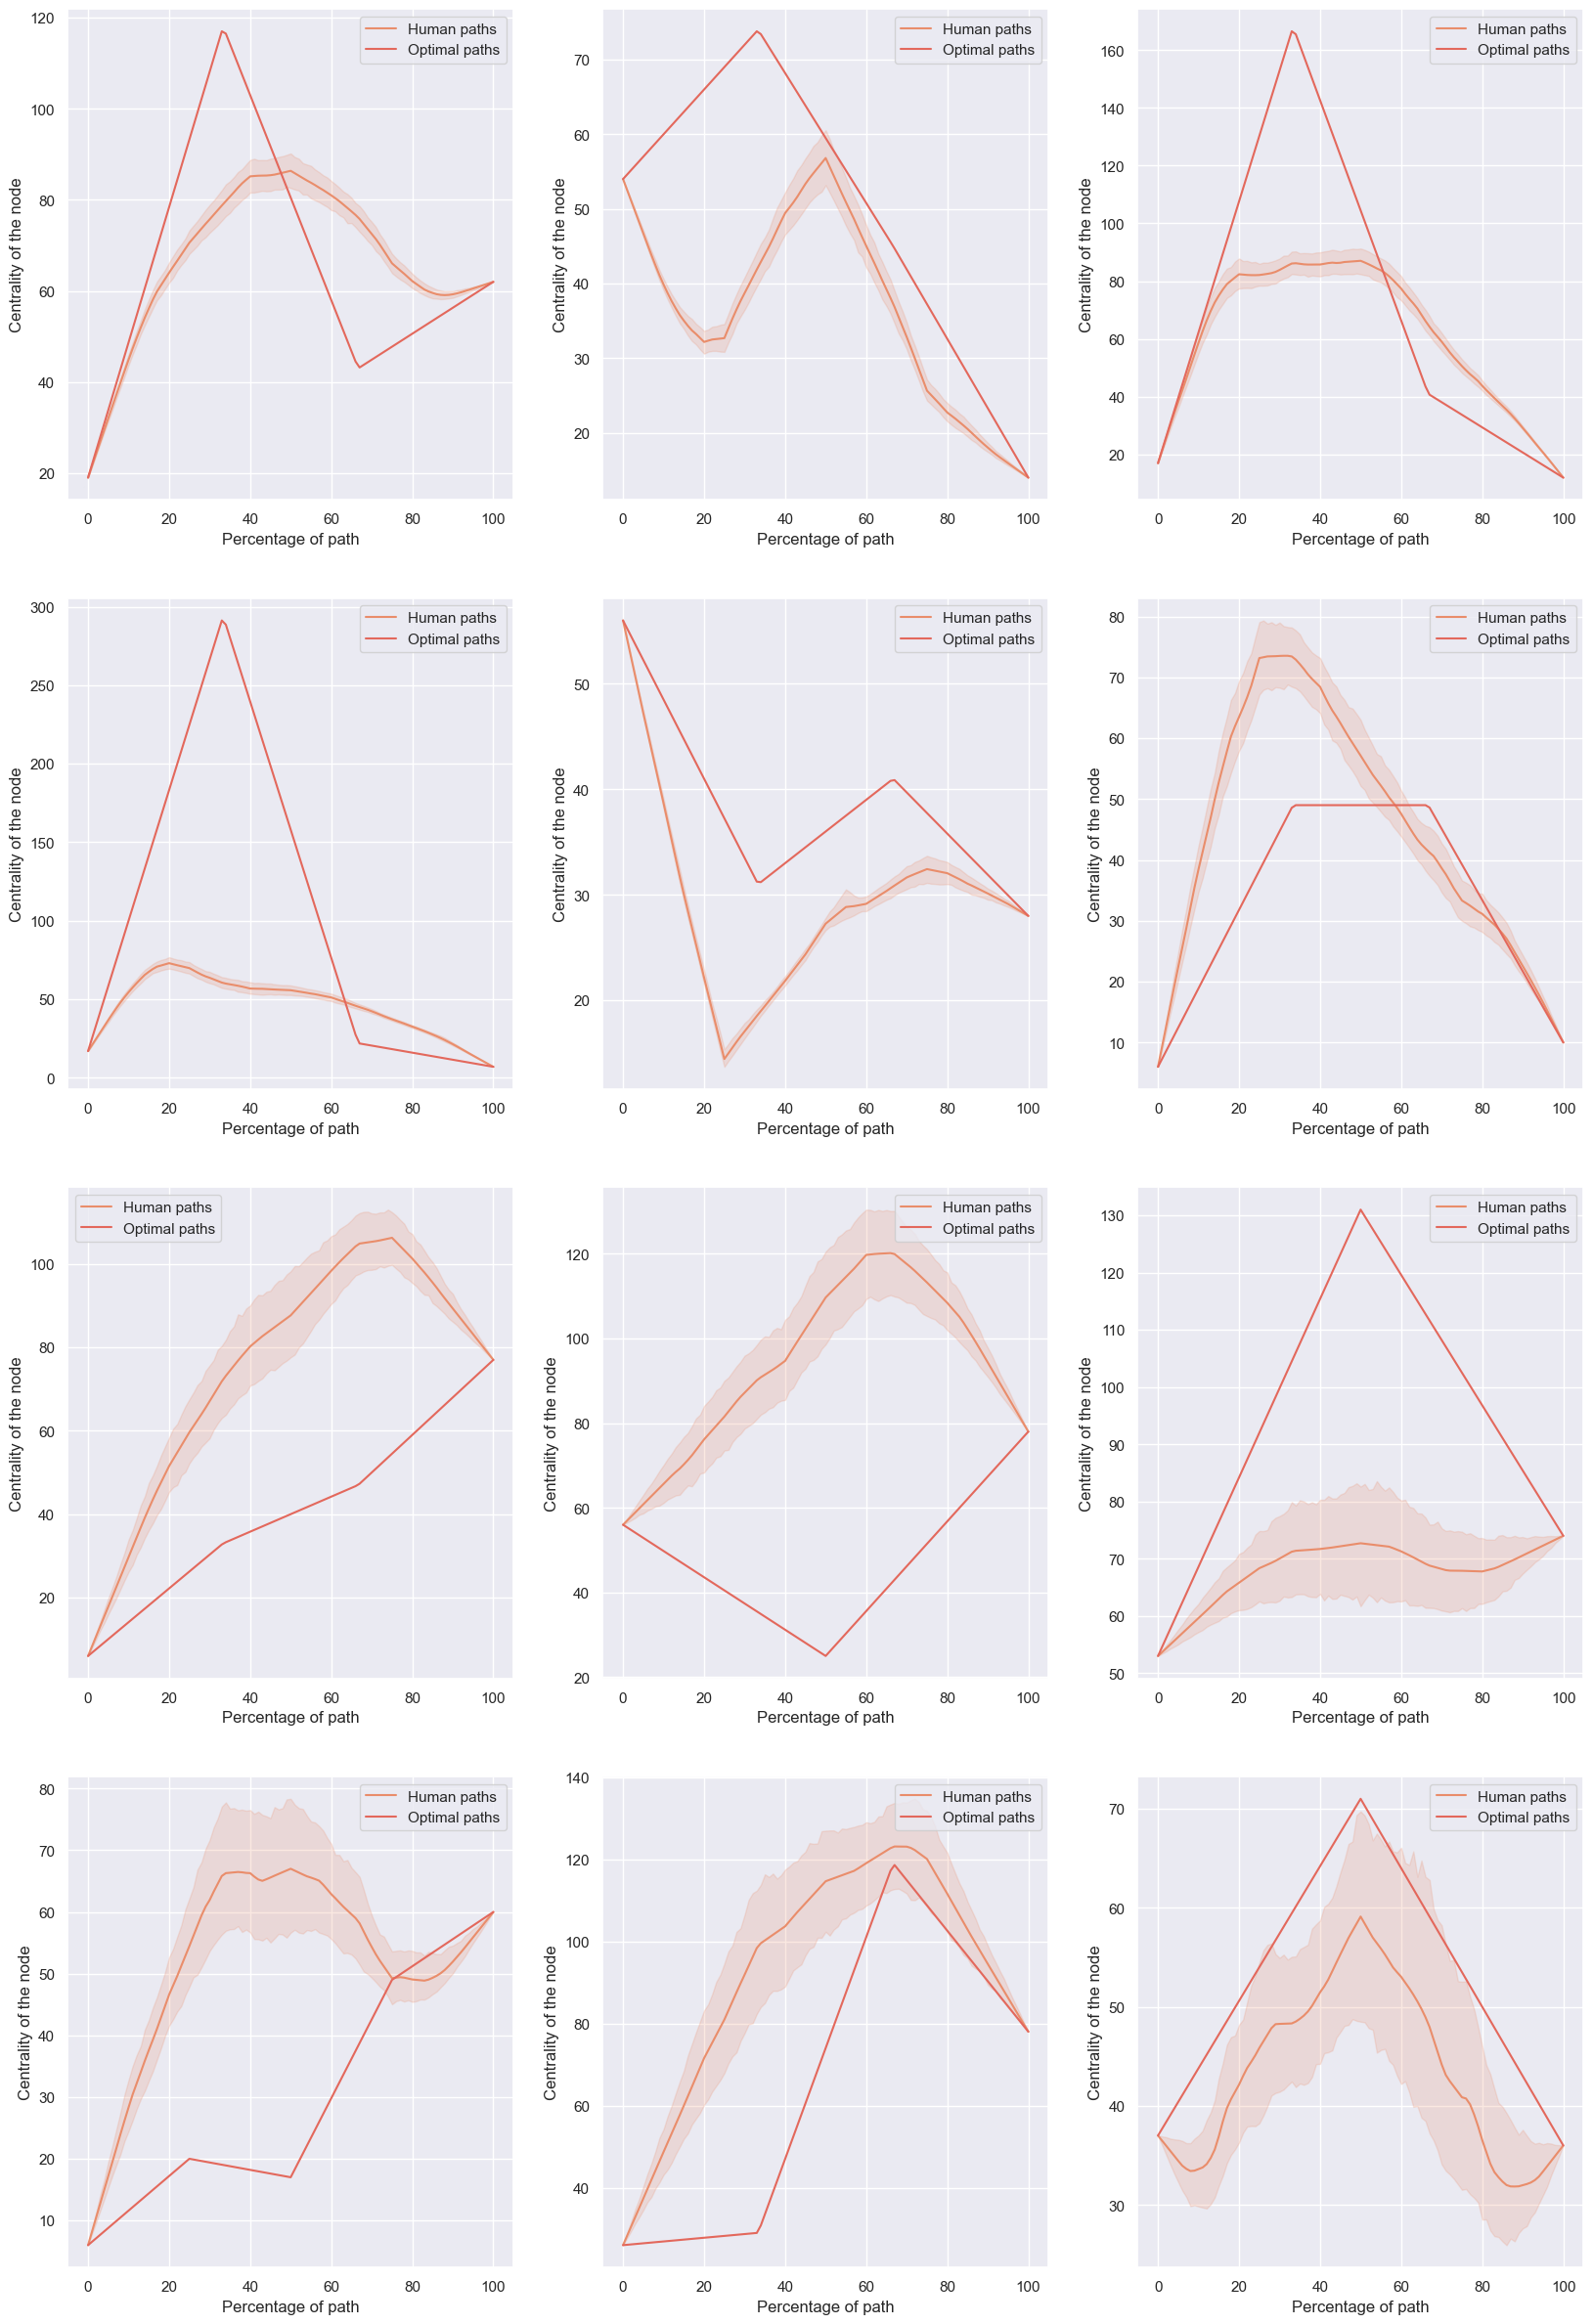

In [73]:
fig , ax = plt.subplots(4,3 ,figsize=(20, 30))
for i,game in enumerate(popular_games):
    compare_optimal_human_paths(game, ax[i//3][i%3], nb_random_paths=1)
plt.show()
